<a href="https://colab.research.google.com/github/anhvt00/NeuroAI-2024/blob/main/TA_W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial1.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D2_ComparingTasks/student/W1D2_Tutorial1.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 1: Task definition, application, relations and impacts on generalization

**Week 1, Day 2: Comparing Tasks**

**By Neuromatch Academy**

__Content creators:__ Deying Song, Leila Wehbe

__Content reviewers:__ Samuele Bolotta, Hlib Solodzhuk, RyeongKyung Yoon, Lily Chamakura, Yizhou Chen, Ruiyi Zhang, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault


___


# Tutorial Objectives

*Estimated timing of tutorial: 90 minutes*

In this tutorial, we'll explore how task specification affects generalization. We will use the same base architecture (a convolutional neural network or CNN) to perform different tasks with different outputs. We will explore the number of training points and number of epochs needed to train these networks. Additionally, we will explore how well representations learned for a given task generalize, and whether they can be used to solve the other tasks.

Today's learning objectives are:

1. Formulate different tasks in terms of cost functions.
2. Train a network to accomplish these tasks and compare the performance of these networks.
3. Measure how well different representations generalize

Let's get started.


In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "x4y79"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



In [2]:
# @title Install and import feedback gadget

!pip install vibecheck numpy matplotlib torch torchvision tqdm ipywidgets memory-profiler requests scikit-learn torchmetrics --quiet


from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D2_T1"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00


In [3]:
# @title Import dependencies

# Import standard library dependencies
import os
import time
import gc
import logging
from pathlib import Path
import zipfile
import random
import contextlib
import io

# Import third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from ipywidgets import Layout
from memory_profiler import profile
import requests
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
import vibecheck

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Helper functions

class BottleneckLayer(nn.Module):

    def __init__(self, M):
        super(BottleneckLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, M)

    def forward(self, x):
        x = F.relu(self.fc(x))
        return x

class ConvNeuralNetDecoder(nn.Module):

    def __init__(self, M):
        super(ConvNeuralNetDecoder, self).__init__()
        self.fc3 = nn.Linear(M, LATENT_DIM)
        self.fc2 = nn.Linear(84, 120)
        self.fc1 = nn.Linear(120, 16 * 5 * 5)

        self.convT2 = nn.ConvTranspose2d(16, 6, 5, stride=2, padding=0, output_padding=1)
        self.convT1 = nn.ConvTranspose2d(6, 1, 5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc1(x))

        x = x.view(-1, 16, 5, 5)

        x = F.relu(self.convT2(x))
        x = self.convT1(x)

        return x

def get_random_sample_dataloader(dataset, batch_size, M):
    indices = torch.randperm(len(dataset))[:M]
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    sampled_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    return sampled_loader

def get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data):

    sampled_train_loader = get_random_sample_dataloader(train_dataset, batch_size, N_train_data)

    N_val_data = int(N_train_data / 9.0)
    if N_val_data < 30:
        N_val_data = int(30)
    sampled_val_loader = get_random_sample_dataloader(val_dataset, batch_size, N_val_data)

    return sampled_train_loader, sampled_val_loader

class Accuracy:
    def __init__(self, task='multiclass', num_classes=10):
        assert task == 'multiclass', "Only supports `multiclass` task accuracy!"
        self.num_classes = num_classes

    def __call__(self, predicted, target):
        correct = predicted.eq(target.view_as(predicted)).sum().item()
        return correct / predicted.size(0)

def save_model(model, task_name, N_train_data, epoch, train_loss, val_loss):
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    MODEL_NAME = f"ConvNet_{task_name}_{N_train_data}_epoch_{epoch}.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saving the model: {MODEL_SAVE_PATH}")

    # Create the checkpoint dictionary including the model state and the loss values
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }

    torch.save(obj=checkpoint, f=MODEL_SAVE_PATH)

def train(model, train_dataloader, val_dataloader, test_dataloader, cost_fn, optimizer, epochs_max, acc_flag, triplet_flag, task_name, N_train_data):
    tstart = time.time()
    accuracy = Accuracy(task='multiclass', num_classes=10)

    epoch = 0
    val_cost_last = 100000.0
    val_cost_current = 100000.0

    my_epoch = []
    my_train_cost = []
    my_test_cost = []

    train_losses = []
    val_losses = []

    if triplet_flag:  # with triplet loss
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            # Training loop
            train_cost = 0.0
            for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_dataloader):
                model.train()
                anchor_reconstruct = model(anchor_img)
                positive_reconstruct = model(positive_img)
                negative_reconstruct = model(negative_img)
                cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                train_cost += cost.item()
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            # Validation loop
            val_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    val_cost += cost.item()
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                val_losses.append(val_cost)

            # Test loop
            test_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(test_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    test_cost += cost.item()
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

            print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                  f"Val cost: {val_cost: .5f}| " +
                  f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    else:  # with loss functions taking two arguments as inputs
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            # Training loop
            train_cost, train_acc = 0.0, 0.0
            for batch_idx, (X, y) in enumerate(train_dataloader):
                model.train()
                predictions = model(X)
                cost = cost_fn(predictions, y)
                train_cost += cost.item()
                if acc_flag:
                    _, predicted_classes = torch.max(predictions, 1)
                    acc = accuracy(predicted_classes, y)
                    train_acc += acc
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            if acc_flag:
                train_acc /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            # Validation loop
            val_cost, val_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(val_dataloader):
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    val_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        val_acc += acc
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                if acc_flag:
                    val_acc /= len(val_dataloader)
            val_losses.append(val_cost)

            # Test loop
            test_cost, test_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(test_dataloader):
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    test_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        test_acc += acc
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

                if acc_flag:
                    test_acc /= len(test_dataloader)

            if acc_flag:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| Train acc: {train_acc: .5f}| " +
                      f"Val cost: {val_cost: .5f}| Val acc: {val_acc: .5f}| " +
                      f"Test cost: {test_cost: .5f}| Test acc: {test_acc: .5f}")
            else:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                      f"Val cost: {val_cost: .5f}| " +
                      f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    elapsed = time.time() - tstart
    print('Elapsed: %s' % elapsed)

    # Save the loss values to a separate file
    loss_data = {'train_losses': train_losses, 'val_losses': val_losses}
    torch.save(loss_data, 'loss_data.pth')

    return my_epoch, my_train_cost, val_losses, my_test_cost


def train_transfer(model, train_dataloader, val_dataloader, test_dataloader, cost_fn, optimizer, epochs_max, acc_flag, triplet_flag, task_name, N_train_data):
    tstart = time.time()
    accuracy = Accuracy(task='multiclass', num_classes=10)

    epoch = 0
    val_cost_last = 100000.0
    val_cost_current = 100000.0

    my_epoch = []
    my_train_cost = []
    my_test_cost = []

    train_losses = []
    val_losses = []

    if triplet_flag:  # with triplet loss
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            # Training loop
            train_cost = 0.0
            for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_dataloader):
                model.train()
                anchor_reconstruct = model(anchor_img)
                positive_reconstruct = model(positive_img)
                negative_reconstruct = model(negative_img)
                cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                train_cost += cost.item()
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            # Validation loop
            val_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    val_cost += cost.item()
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                val_losses.append(val_cost)

            # Test loop
            test_cost = 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(test_dataloader):
                    anchor_reconstruct = model(anchor_img)
                    positive_reconstruct = model(positive_img)
                    negative_reconstruct = model(negative_img)
                    cost = cost_fn(anchor_reconstruct, positive_reconstruct, negative_reconstruct)
                    test_cost += cost.item()
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

            print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                  f"Val cost: {val_cost: .5f}| " +
                  f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    else:  # with loss functions taking two arguments as inputs
        for epoch in tqdm(range(1, epochs_max + 1), desc="Training epochs", unit="epoch"):
            my_epoch.append(epoch)

            # Training loop
            train_cost, train_acc = 0.0, 0.0
            for batch_idx, (X, y) in enumerate(train_dataloader):
                model.train()
                predictions = model(X)
                cost = cost_fn(predictions, y)
                train_cost += cost.item()
                if acc_flag:
                    _, predicted_classes = torch.max(predictions, 1)
                    acc = accuracy(predicted_classes, y)
                    train_acc += acc
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
            train_cost /= len(train_dataloader)
            if acc_flag:
                train_acc /= len(train_dataloader)
            train_losses.append(train_cost)
            my_train_cost.append(train_cost)

            # Validation loop
            val_cost, val_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(val_dataloader):
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    val_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        val_acc += acc
                val_cost /= len(val_dataloader)
                val_cost_last = val_cost_current
                val_cost_current = val_cost
                if acc_flag:
                    val_acc /= len(val_dataloader)
            val_losses.append(val_cost)

            # Test loop
            test_cost, test_acc = 0.0, 0.0
            model.eval()
            with torch.no_grad():
                for batch_idx, (X, y) in enumerate(test_dataloader):
                    predictions = model(X)
                    cost = cost_fn(predictions, y)
                    test_cost += cost.item()
                    if acc_flag:
                        _, predicted_classes = torch.max(predictions, 1)
                        acc = accuracy(predicted_classes, y)
                        test_acc += acc
                test_cost /= len(test_dataloader)
                my_test_cost.append(test_cost)

                if acc_flag:
                    test_acc /= len(test_dataloader)

            if acc_flag:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| Train acc: {train_acc: .5f}| " +
                      f"Val cost: {val_cost: .5f}| Val acc: {val_acc: .5f}| " +
                      f"Test cost: {test_cost: .5f}| Test acc: {test_acc: .5f}")
            else:
                print(f"Epoch: {epoch}| Train cost: {train_cost: .5f}| " +
                      f"Val cost: {val_cost: .5f}| " +
                      f"Test cost: {test_cost: .5f}|")

            save_model(model, task_name, N_train_data, epoch, train_cost, val_cost)

    elapsed = time.time() - tstart
    print('Elapsed: %s' % elapsed)

    # Save the loss values to a separate file
    loss_data = {'train_losses': train_losses, 'val_losses': val_losses}
    torch.save(loss_data, 'loss_data.pth')

    return my_epoch, my_train_cost, val_losses, my_test_cost

In [6]:
# @title Plotting functions

def plot_reconstructions(original_images, reconstructed_images, N_train_data, epochs):
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 2, 6
    image_count = 0
    for i in range(1, rows * cols, 2):
        fig.add_subplot(rows, cols, i)
        plt.imshow(np.squeeze(original_images[image_count]), cmap='gray')
        plt.title(f"Original {image_count+1}", fontsize=8)
        plt.axis('off')

        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(np.squeeze(reconstructed_images[image_count]), cmap='gray')
        plt.title(f"Reconstructed {image_count+1}", fontsize=8)
        plt.axis('off')

        image_count += 1
    fig.suptitle(f"Training for {epochs} epochs with {N_train_data} points")
    plt.show()

In [7]:
# @title Data retrieval

import os
import requests
import hashlib
import zipfile

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
            return
        if hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
            return
        with open(fname, "wb") as fid:
            fid.write(r.content)

def extract_zip(zip_fname):
    """
    Extracts a ZIP file to the current directory.
    """
    with zipfile.ZipFile(zip_fname, 'r') as zip_ref:
        zip_ref.extractall(".")

# Details for the zip files to be downloaded and extracted
zip_files = [
    {
        "fname": "models.zip",
        "url": "https://osf.io/dms2n/download",
        "expected_md5": "2c88be8804ae546da6c6985226bc98e7"
    }
]

# Process zip files: download and extract
for zip_file in zip_files:
    download_file(zip_file["fname"], zip_file["url"], zip_file["expected_md5"])
    extract_zip(zip_file["fname"])

In [8]:
# @title Set random seed

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

---
# Section 1: Formalize different tasks as cost functions and train the same architecture to achieve these tasks

In [9]:
# @title Tutorial Video

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'HxovwyQTi0o'), ('Bilibili', 'BV1Ri421e7mR')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [10]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Tutorial_Video")

## Review of CNNs

In this tutorial, we will use a simple Convolutional Neural Network (CNN) architecture and a subset of the MNIST dataset, which consists of images of handwritten digits. We will use the same base architecture and training datasets to accomplish different tasks by creating various output layers and training them with different objective functions.

A Convolutional Neural Network (CNN) is a deep learning algorithm designed to process input images, assign importance (learnable weights and biases) to various features within the images, and distinguish between different objects. Unlike pure feedforward neural networks that flatten the input into a one-dimensional array, CNNs preserve the spatial hierarchy of the input images. This makes them particularly effective for processing data with a grid-like structure, such as images. A CNN architecture is engineered to automatically and adaptively learn spatial hierarchies of features, ranging from low-level to high-level patterns.

The core components of CNNs are convolutional layers, pooling layers, and fully connected layers. A schematic of a CNN is shown below.

- Convolutional layers apply convolution operations to the input and pass the results to the next layer. This enables the network to be deep with fewer parameters, enhancing the learning of feature hierarchies.
- Pooling layers reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer.
- Fully connected layers connect every neuron in one layer to every neuron in the next layer and are typically used at the end of the network to make class predictions.

Due to their ability to capture the spatial and temporal dependencies in images through the application of relevant filters, CNNs are extensively used in image and video recognition, recommender systems, image classification, medical image analysis, and natural language processing.

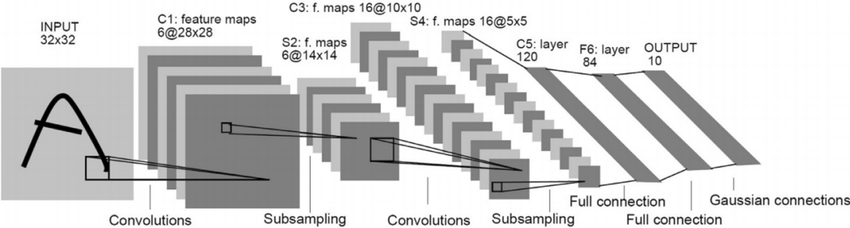

Here we'll replicate the structure of LeNet up to the fully connected `fc2` layer. The latent representation in this layer is 84 dimensional. We'll add various decoder heads and bottleneck layers to this core, train on different objectives, and see how the representations change.

In [11]:
LATENT_DIM = 84
class ConvNeuralNet(nn.Module):

    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, LATENT_DIM)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### Preparing the data

In [12]:
with contextlib.redirect_stdout(io.StringIO()):

    # Define a transformation pipeline for the MNIST dataset
    mnist_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize the images to 32x32 pixels
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize the images with mean and standard deviation
    ])

    # Load the MNIST training dataset with transformations applied
    train_val_dataset = torchvision.datasets.MNIST(
        root='./data',  # Directory to store/load the data
        train=True,  # Specify to load the training set
        transform=mnist_transform,  # Apply the transformation pipeline defined earlier
        download=True  # Download the dataset if it's not already present
    )

    # Load the MNIST test dataset with transformations applied
    test_dataset = torchvision.datasets.MNIST(
        root='./data',  # Directory to store/load the data
        train=False,  # Specify to load the test set
        transform=mnist_transform,  # Apply the transformation pipeline defined earlier
        download=True  # Download the dataset if it's not already present
    )

    # Split the training dataset into training and validation sets
    train_size = int(0.9 * len(train_val_dataset))  # Calculate the size of the training set (90% of the original)
    val_size = len(train_val_dataset) - train_size  # Calculate the size of the validation set (remaining 10%)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset=train_val_dataset,  # Original training dataset to split
        lengths=[train_size, val_size]  # Lengths of the resulting splits
    )

    # Split the test dataset into two halves: original and transfer sets
    test_size_original = int(0.5 * len(test_dataset))  # Calculate the size of the original test set (50% of the original)
    test_size_transfer = len(test_dataset) - test_size_original  # Calculate the size of the transfer test set (remaining 50%)
    test_dataset_original, test_dataset_transfer = torch.utils.data.random_split(
        dataset=test_dataset,  # Original test dataset to split
        lengths=[test_size_original, test_size_transfer]  # Lengths of the resulting splits
    )

    # Display the training dataset object
    train_dataset

100%|██████████| 4542/4542 [00:00<00:00, 7135029.50it/s]


### Visualizing some samples from the dataset

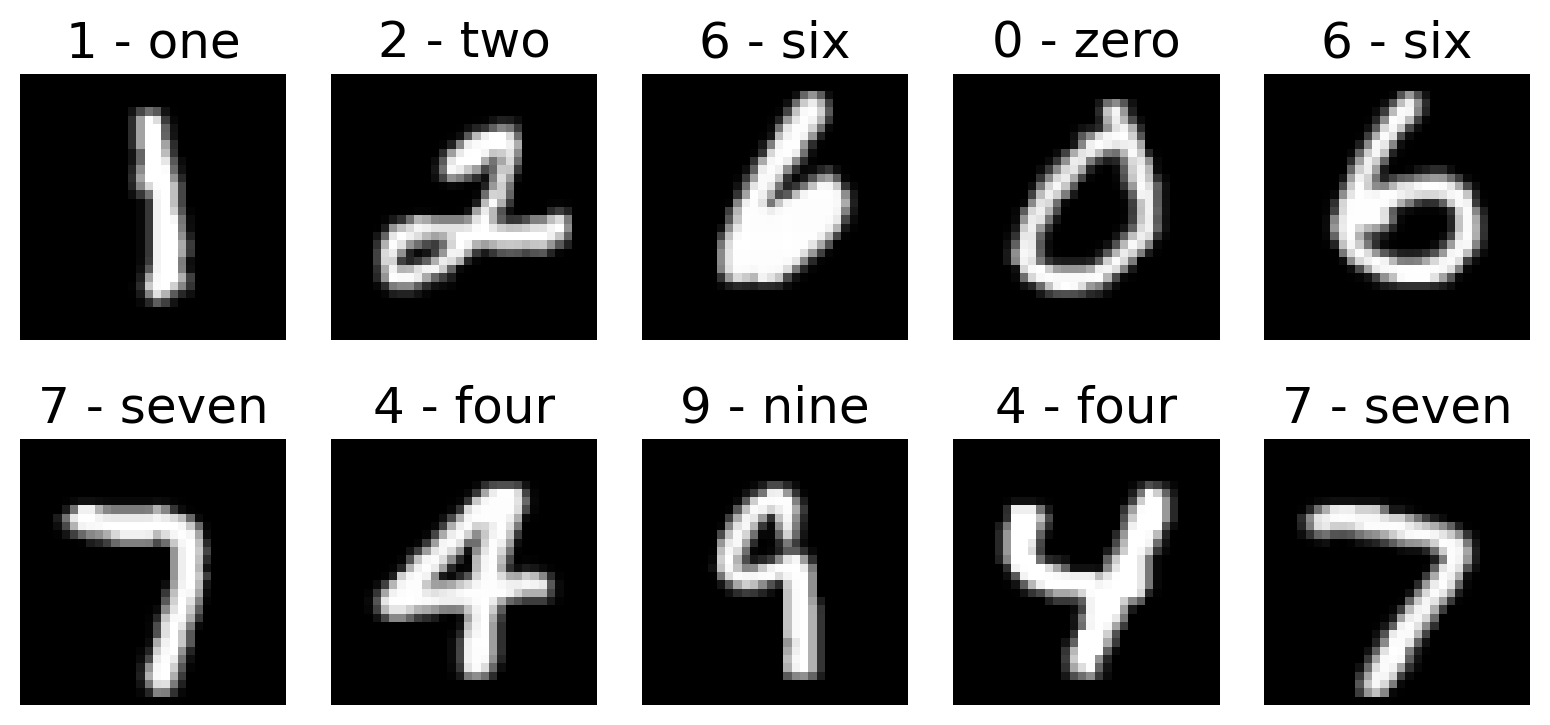

In [13]:
# Retrieve the class names (labels) from the training dataset
class_names = train_dataset.dataset.classes

# Set a manual seed for PyTorch to ensure reproducibility of results
torch.manual_seed(10)

# Create a figure for displaying the images
fig = plt.figure(figsize=(8, 4))  # Set the figure size to 8x4 inches
rows, cols = 2, 5  # Define the number of rows and columns for the subplot grid

# Define the mean and standard deviation used for normalization
mean = 0.1307
std = 0.3081

# Loop to display a grid of sample images from the training dataset
for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    img_tensor = img * std + mean
    img_tensor = img_tensor / 2 + 0.5
    img_np = np.squeeze(img_tensor.numpy())
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

### Preparing the data loaders

In [14]:
batch_size = 32

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the validation dataset
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the original test dataset
test_loader_original = torch.utils.data.DataLoader(
    dataset=test_dataset_original,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

# Create a DataLoader for the transfer test dataset
test_loader_transfer = torch.utils.data.DataLoader(
    dataset=test_dataset_transfer,  # The dataset to load data from
    batch_size=batch_size,  # The number of samples per batch
    shuffle=True  # Shuffle the data at every epoch
)

In [15]:
# Defining epochs and batch size
epochs_max = 20
batch_size = 32

## Section 1.1: Classification

In this task, we'll train the CNN to classify digits into one of 10 different classes.

### Code exercise 1: Cost Function

#### Training

In this task, we aim to classify hand-written digits from images, where each digit ranges from 0 to 9. To achieve this, we add a classification head to the CNN.

We introduce an output layer Y with 10 nodes, each representing one of the possible digits. The output layer uses the softmax activation function to produce probability scores for each class:

$$p(y=j|x) = \frac{e^{\mu_j}}{\sum_{k=1}^{10} e^{\mu_k}}$$

where $\mu_j = \text{CNN}_j(x)$ is the output of the $j^{th}$ node in the output layer.

In [16]:
class ClassificationOutputLayer(nn.Module):

    def __init__(self):
        super(ClassificationOutputLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, 10)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=1)

        return x

Thus, the network outputs a probability distribution over the 10 possible classes for each input image.

#### Cost Function

To train the network effectively, we implement a cost function based on the cross-entropy. The loss function is:

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{10} y_{ij} \log(p(y_{ij}|x_i))$$

where:

* $N$ is the number of samples
* $y_{ij}$ is the true label for the $i^{th}$ sample, encoded as a one-hot vector
* $p(y_{ij}|x_i)$ is the predicted probability of the $j^{th}$ class for the $i^{th}$ sample.

In [17]:
def cost_classification(output, target):

    ############################################################
    # Hint for batch_size: Get the first dimension of the target tensor
    # Hint for cost: Calculate the loss using the criterion
    # raise NotImplementedError("Student has to fill in these lines")
    ############################################################

    criterion = nn.CrossEntropyLoss()
    target = target.to(torch.int64)
    cost = criterion(output, target)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_53f79ab6.py)



By implementing this cost function, the model is trained to minimize the difference between the predicted probability distributions and the actual one-hot encoded targets.

In [18]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function")

### Defining the model

We define a CNN model with a classification head to classify the digits.

In [19]:
class ClassificationConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(ClassificationConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

Here, ConvNet represents the convolutional part of the network responsible for feature extraction, while Output is the classification output layer described earlier.

### Training on varying datapoints

We conduct training experiments with this model on varying dataset sizes (10, 100, 1000, 10000). This approach helps us understand how the model's performance scales with the amount of training data available (sample complexity). Larger datasets typically improve the model's ability to generalize to the test set.

In [20]:
set_seed(42)

# Usage example for classification task
training_points = np.array([10, 100, 1000, 10000])
task_name_classification = "classification"
acc_flag_classification = True
triplet_flag_classification = False
epochs_max_classification = 10

for N_train_data in training_points:
    model = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Update the train function call to get training costs
    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(model, sampled_train_loader, sampled_val_loader, test_loader_original, cost_classification, optimizer, epochs_max_classification, acc_flag_classification, triplet_flag_classification, task_name_classification, N_train_data)

    if N_train_data == 10:
        my_epoch_Classification = [my_epoch]
        my_train_cost_Classification = [my_train_cost]  # Add a list to store training costs
        my_val_cost_Classification = [my_val_cost] # Add a list to store val costs
        my_test_cost_Classification = [my_test_cost]  # Add a list to store test costs
    else:
        my_epoch_Classification.append(my_epoch)
        my_train_cost_Classification.append(my_train_cost)  # Append the training costs
        my_val_cost_Classification.append(my_val_cost)  # Append the training costs
        my_test_cost_Classification.append(my_test_cost)  # Append the training costs


    # Compute predictions and confusion matrix for the validation set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(sampled_val_loader):
            predictions = model(X)
            _, predicted_classes = torch.max(predictions, 1)
            all_preds.extend(predicted_classes.numpy())
            all_labels.extend(y.numpy())

    #Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    if N_train_data == 10:
        conf_matrices = [(N_train_data, conf_matrix)] # List to store confusion matrices
    else:
        conf_matrices.append((N_train_data, conf_matrix))  # Store the confusion matrix with the number of training points

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.30030| Train acc:  0.20000| Val cost:  2.30344| Val acc:  0.10000| Test cost:  2.30159| Test acc:  0.09972
Saving the model: models/ConvNet_classification_10_epoch_1.pth
Epoch: 2| Train cost:  2.29476| Train acc:  0.20000| Val cost:  2.30213| Val acc:  0.10000| Test cost:  2.30087| Test acc:  0.10171
Saving the model: models/ConvNet_classification_10_epoch_2.pth
Epoch: 3| Train cost:  2.28905| Train acc:  0.30000| Val cost:  2.30084| Val acc:  0.10000| Test cost:  2.30005| Test acc:  0.13256
Saving the model: models/ConvNet_classification_10_epoch_3.pth
Epoch: 4| Train cost:  2.28218| Train acc:  0.40000| Val cost:  2.29938| Val acc:  0.10000| Test cost:  2.29908| Test acc:  0.15545
Saving the model: models/ConvNet_classification_10_epoch_4.pth
Epoch: 5| Train cost:  2.27340| Train acc:  0.40000| Val cost:  2.29780| Val acc:  0.10000| Test cost:  2.29780| Test acc:  0.16939
Saving the model: models/ConvNet_classification_10_epoch_5.pth
Epoch: 6| Train cost:  2.

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.30145| Train acc:  0.12500| Val cost:  2.30260| Val acc:  0.03333| Test cost:  2.29929| Test acc:  0.10251
Saving the model: models/ConvNet_classification_100_epoch_1.pth
Epoch: 2| Train cost:  2.29435| Train acc:  0.16406| Val cost:  2.30231| Val acc:  0.03333| Test cost:  2.29509| Test acc:  0.10251
Saving the model: models/ConvNet_classification_100_epoch_2.pth
Epoch: 3| Train cost:  2.28765| Train acc:  0.10938| Val cost:  2.30112| Val acc:  0.03333| Test cost:  2.28653| Test acc:  0.10191
Saving the model: models/ConvNet_classification_100_epoch_3.pth
Epoch: 4| Train cost:  2.26805| Train acc:  0.17188| Val cost:  2.28035| Val acc:  0.10000| Test cost:  2.26718| Test acc:  0.15028
Saving the model: models/ConvNet_classification_100_epoch_4.pth
Epoch: 5| Train cost:  2.26067| Train acc:  0.14062| Val cost:  2.25135| Val acc:  0.16667| Test cost:  2.24029| Test acc:  0.18213
Saving the model: models/ConvNet_classification_100_epoch_5.pth
Epoch: 6| Train cost

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.22031| Train acc:  0.30566| Val cost:  2.11127| Val acc:  0.38125| Test cost:  2.06095| Test acc:  0.46158
Saving the model: models/ConvNet_classification_1000_epoch_1.pth
Epoch: 2| Train cost:  1.94405| Train acc:  0.54297| Val cost:  1.96304| Val acc:  0.53177| Test cost:  1.86316| Test acc:  0.60768
Saving the model: models/ConvNet_classification_1000_epoch_2.pth
Epoch: 3| Train cost:  1.84798| Train acc:  0.61816| Val cost:  1.90293| Val acc:  0.54844| Test cost:  1.82744| Test acc:  0.63336
Saving the model: models/ConvNet_classification_1000_epoch_3.pth
Epoch: 4| Train cost:  1.75932| Train acc:  0.71973| Val cost:  1.74465| Val acc:  0.72240| Test cost:  1.71468| Test acc:  0.76055
Saving the model: models/ConvNet_classification_1000_epoch_4.pth
Epoch: 5| Train cost:  1.67826| Train acc:  0.78906| Val cost:  1.74314| Val acc:  0.72917| Test cost:  1.68728| Test acc:  0.77667
Saving the model: models/ConvNet_classification_1000_epoch_5.pth
Epoch: 6| Train

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  1.69805| Train acc:  0.78365| Val cost:  1.54355| Val acc:  0.92589| Test cost:  1.53729| Test acc:  0.93073
Saving the model: models/ConvNet_classification_10000_epoch_1.pth
Epoch: 2| Train cost:  1.52869| Train acc:  0.93510| Val cost:  1.51372| Val acc:  0.95446| Test cost:  1.51225| Test acc:  0.95064
Saving the model: models/ConvNet_classification_10000_epoch_2.pth
Epoch: 3| Train cost:  1.50787| Train acc:  0.95567| Val cost:  1.50797| Val acc:  0.95625| Test cost:  1.50755| Test acc:  0.95402
Saving the model: models/ConvNet_classification_10000_epoch_3.pth
Epoch: 4| Train cost:  1.49848| Train acc:  0.96466| Val cost:  1.50773| Val acc:  0.95858| Test cost:  1.50200| Test acc:  0.96019
Saving the model: models/ConvNet_classification_10000_epoch_4.pth
Epoch: 5| Train cost:  1.49475| Train acc:  0.96795| Val cost:  1.49820| Val acc:  0.96269| Test cost:  1.49147| Test acc:  0.96994
Saving the model: models/ConvNet_classification_10000_epoch_5.pth
Epoch: 6| 

### Test performance

The test performance of the model is evaluated by plotting the test cost across training epochs for different sample sizes.

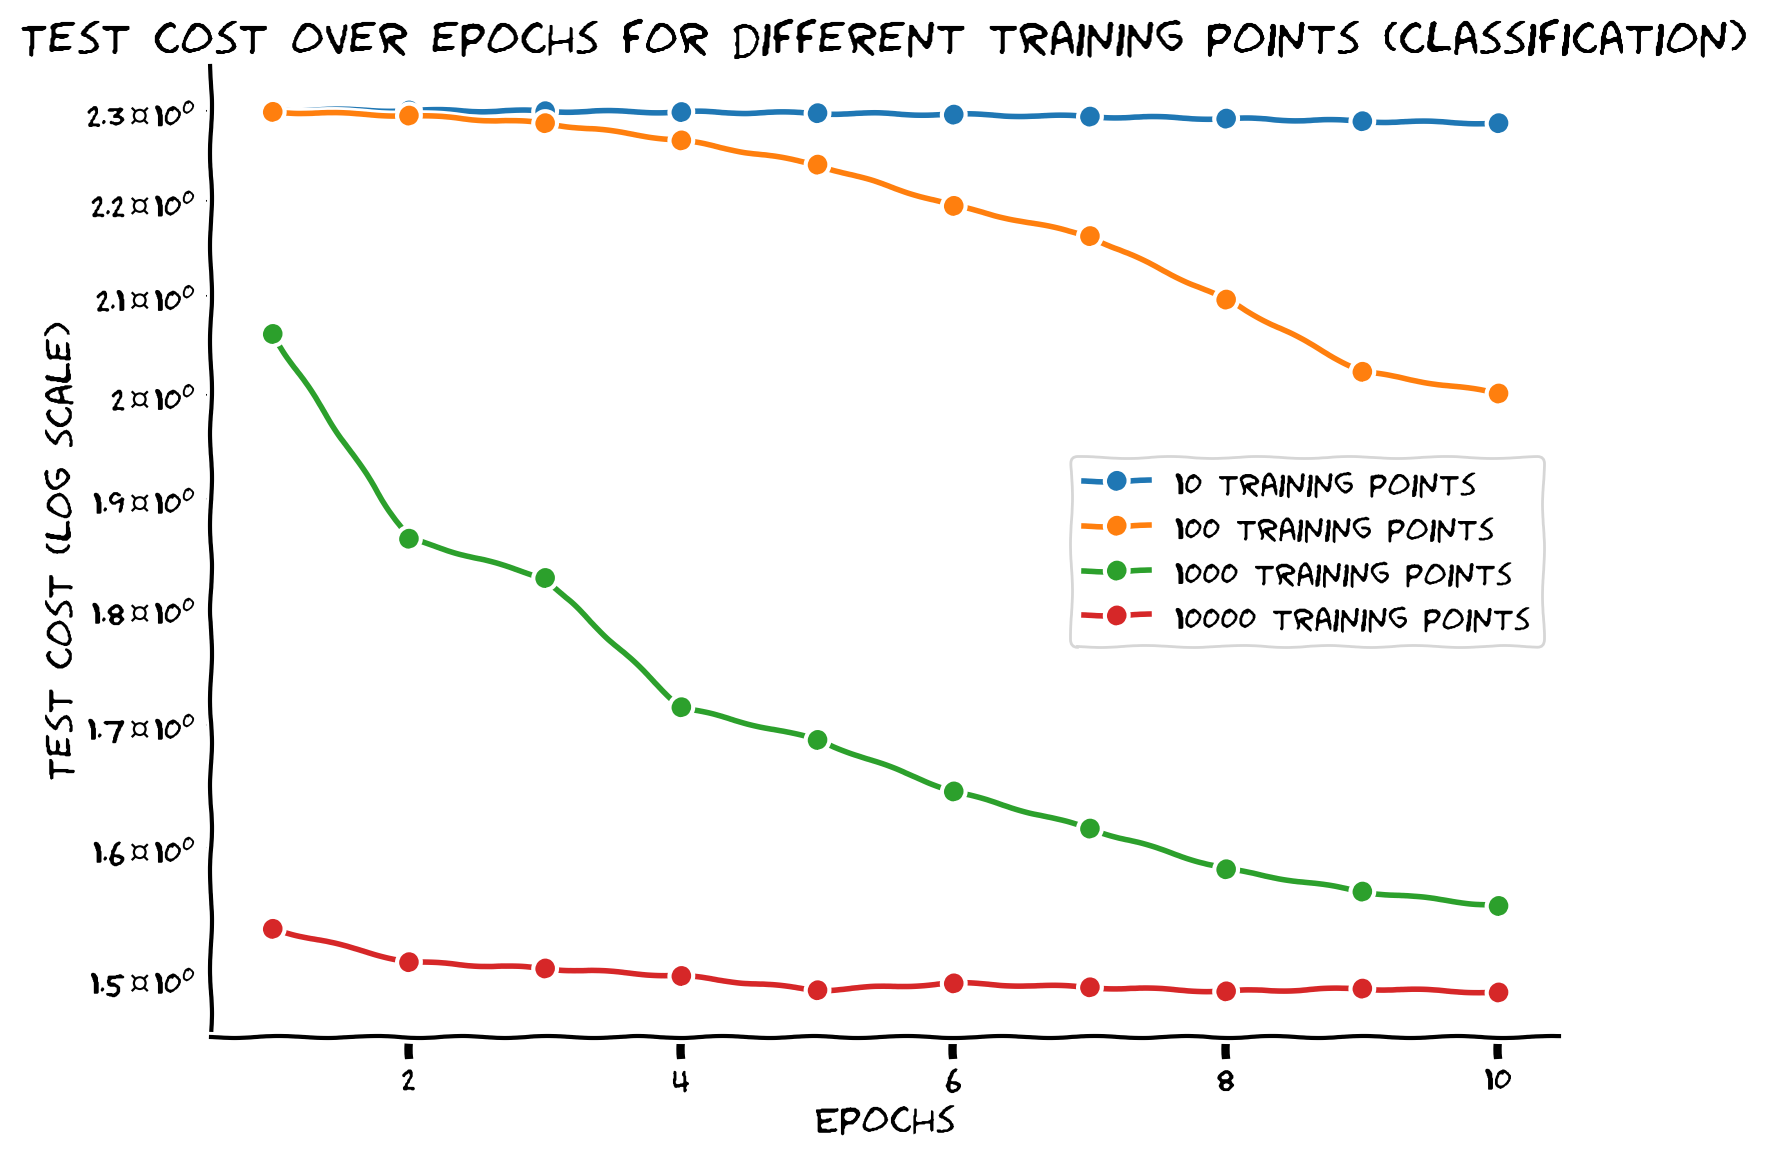

In [21]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Classification[i]
        test_cost = my_test_cost_Classification[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (classification)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

### Discussion point 1

Now that you have trained your network with different sample sizes, plot the performance on the test dataset for each network across epochs. How does sample size interact with number of training epochs?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_28d9d52f.py)



In [22]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_1")

## Section 1.2: Regression

After examining the use of network architecture for digit classification, we now transition to a regression task using the same architecture. We are going to pick a very simple output task, which is not directly related to classification or the identify of the digits. In this task, given an image of a handwritten digit, our objective is to predict the number of pixels that are 'ON' (i.e., pixel values greater than 0.5). This can be achieved with the network performing operations similar to a simple addition of the pixels (though it might still take time and data for the network to find this simple solution). Thus, we don't expect that the network will learn rich representations that are useful for other tasks such as classification.

### Task objective

This regression task, while relatively simple as it involves summing pixel values, serves to illustrate how well a Convolutional Neural Network (CNN) can adapt to learning a continuous output instead of discrete class labels. Note that we'll regress the normalized

### Output layer

The output layer for this regression task consists of a single node that predicts the number of 'ON' pixels in the image. This necessitates a different cost function compared to the classification task.

In [23]:
class RegressionOutputLayer(nn.Module):

    def __init__(self):
        super(RegressionOutputLayer, self).__init__()
        self.fc = nn.Linear(LATENT_DIM, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

Here, the `RegressionOutputLayer` outputs a single continuous value.

### Code exercise 2: Cost function

Here we implement the mean squared error loss, which measures the average squared difference between the predicted and actual values:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \mu_i)^2$$

where:

- $N$ is the number of samples
- $y_i$ is the true label for the $i^{th}$ sample, the number of on pixels
- $\mu_i = \text{CNN}(x_i)$ is the output of the model for the $i^{th}$ sample

In [24]:
def cost_regression(output, target):
    ############################################################
    # Hint for criterion: The criterion used for regression tasks is designed
    # to minimize the average squared difference between predicted and actual values.
    # Hint for cost: To compute the cost, apply the criterion function to
    # the predicted output and the actual target values, which will return the mean squared error loss.
    # raise NotImplementedError("Student exercise")
    ############################################################
    criterion = nn.MSELoss()
    cost = criterion(output, target)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_5ddb1f2c.py)



In [25]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function_2")

This cost function computes the MSE loss between the predicted number of 'ON' pixels and the actual count, guiding the model to make accurate continuous predictions.

### Training

We train the network on varying dataset sizes (10, 100, 1000, 10000) to observe the impact of sample size on the model's performance.

In [26]:
class RegressionConvNet(nn.Module):

    def __init__(self, ConvNet, Output):
        super(RegressionConvNet, self).__init__()
        self.ConvNet = ConvNet
        self.Output = Output

    def forward(self, x):
        conv_intermediate = self.ConvNet(x)
        output = self.Output(conv_intermediate)

        return output

The RegressionConvNet integrates the convolutional feature extraction network with the regression output layer.

### Dataset preparation

We adapt the MNIST dataset for the regression task by computing the number of 'ON' pixels for each image.

In [27]:
class RegressionMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset.dataset

    def __getitem__(self, index):
        X, _ = self.dataset[index]
        updated_label = torch.sum(X > 0.0).float() / X.shape[-1] ** 2 - 0.1307
        return X, updated_label

    def __len__(self):
        return len(self.dataset)

This custom dataset class transforms the images and computes the target values required for regression.

### Model training and evaluation

We initialize datasets and data loaders for the regression task, and define functions to evaluate models across different sample sizes.

In [28]:
set_seed(42)

training_points = np.array([10, 100, 1000, 10000])
task_name_regression = "regression"
acc_flag = False
triplet_flag = False
epochs_max_regression = 10

train_dataset_regression = RegressionMNIST(train_dataset)
val_dataset_regression = RegressionMNIST(val_dataset)
test_dataset_original_regression = RegressionMNIST(test_dataset_original)
test_loader_original_regression = torch.utils.data.DataLoader(dataset = test_dataset_original_regression,
                                           batch_size = batch_size,
                                           shuffle = True)

for N_train_data in training_points:
    model = RegressionConvNet(ConvNeuralNet(), RegressionOutputLayer())

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset_regression, val_dataset_regression, batch_size, N_train_data)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(model, sampled_train_loader, sampled_val_loader, test_loader_original_regression, cost_regression, optimizer, epochs_max_regression, acc_flag, triplet_flag, task_name_regression, N_train_data)
    if N_train_data == 10:
        my_epoch_Regression = [my_epoch]
        my_train_cost_Regression= [my_train_cost]
        my_val_cost_Regression= [my_val_cost]
        my_test_cost_Regression= [my_test_cost]
    else:
        my_epoch_Regression.append(my_epoch)
        my_train_cost_Regression.append(my_train_cost)  # Append the training costs
        my_val_cost_Regression.append(my_val_cost)  # Append the val costs
        my_test_cost_Regression.append(my_test_cost)  # Append the test costs

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch: 1| Train cost:  0.00267| Val cost:  0.02717| Test cost:  0.02624|
Saving the model: models/ConvNet_regression_10_epoch_1.pth
Epoch: 2| Train cost:  0.01898| Val cost:  0.00730| Test cost:  0.00691|
Saving the model: models/ConvNet_regression_10_epoch_2.pth
Epoch: 3| Train cost:  0.00361| Val cost:  0.00320| Test cost:  0.00301|
Saving the model: models/ConvNet_regression_10_epoch_3.pth
Epoch: 4| Train cost:  0.00313| Val cost:  0.00431| Test cost:  0.00419|
Saving the model: models/ConvNet_regression_10_epoch_4.pth
Epoch: 5| Train cost:  0.00580| Val cost:  0.00449| Test cost:  0.00437|
Saving the model: models/ConvNet_regression_10_epoch_5.pth
Epoch: 6| Train cost:  0.00594| Val cost:  0.00393| Test cost:  0.00380|
Saving the model: models/ConvNet_regression_10_epoch_6.pth
Epoch: 7| Train cost:  0.00483| Val cost:  0.00340| Test cost:  0.00324|
Saving the model: models/ConvNet_regression_10_epoch_7.pth
Epoch: 8| Train cost:  0.00368| Val cost:  0.00314| Test cost:  0.00295|
Sav

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1| Train cost:  0.00471| Val cost:  0.00265| Test cost:  0.00336|
Saving the model: models/ConvNet_regression_100_epoch_1.pth
Epoch: 2| Train cost:  0.00352| Val cost:  0.00230| Test cost:  0.00295|
Saving the model: models/ConvNet_regression_100_epoch_2.pth
Epoch: 3| Train cost:  0.00279| Val cost:  0.00258| Test cost:  0.00311|
Saving the model: models/ConvNet_regression_100_epoch_3.pth
Epoch: 4| Train cost:  0.00251| Val cost:  0.00248| Test cost:  0.00302|
Saving the model: models/ConvNet_regression_100_epoch_4.pth
Epoch: 5| Train cost:  0.00324| Val cost:  0.00231| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_100_epoch_5.pth
Epoch: 6| Train cost:  0.00261| Val cost:  0.00227| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_100_epoch_6.pth
Epoch: 7| Train cost:  0.00248| Val cost:  0.00228| Test cost:  0.00291|
Saving the model: models/ConvNet_regression_100_epoch_7.pth
Epoch: 8| Train cost:  0.00289| Val cost:  0.00228| Test cost:  0.002

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1| Train cost:  0.00513| Val cost:  0.00351| Test cost:  0.00298|
Saving the model: models/ConvNet_regression_1000_epoch_1.pth
Epoch: 2| Train cost:  0.00303| Val cost:  0.00361| Test cost:  0.00293|
Saving the model: models/ConvNet_regression_1000_epoch_2.pth
Epoch: 3| Train cost:  0.00303| Val cost:  0.00372| Test cost:  0.00308|
Saving the model: models/ConvNet_regression_1000_epoch_3.pth
Epoch: 4| Train cost:  0.00310| Val cost:  0.00321| Test cost:  0.00292|
Saving the model: models/ConvNet_regression_1000_epoch_4.pth
Epoch: 5| Train cost:  0.00306| Val cost:  0.00325| Test cost:  0.00294|
Saving the model: models/ConvNet_regression_1000_epoch_5.pth
Epoch: 6| Train cost:  0.00331| Val cost:  0.00386| Test cost:  0.00306|
Saving the model: models/ConvNet_regression_1000_epoch_6.pth
Epoch: 7| Train cost:  0.00305| Val cost:  0.00322| Test cost:  0.00290|
Saving the model: models/ConvNet_regression_1000_epoch_7.pth
Epoch: 8| Train cost:  0.00304| Val cost:  0.00315| Test cost:

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1| Train cost:  0.00293| Val cost:  0.00310| Test cost:  0.00293|
Saving the model: models/ConvNet_regression_10000_epoch_1.pth
Epoch: 2| Train cost:  0.00290| Val cost:  0.00307| Test cost:  0.00291|
Saving the model: models/ConvNet_regression_10000_epoch_2.pth
Epoch: 3| Train cost:  0.00290| Val cost:  0.00306| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_3.pth
Epoch: 4| Train cost:  0.00289| Val cost:  0.00305| Test cost:  0.00288|
Saving the model: models/ConvNet_regression_10000_epoch_4.pth
Epoch: 5| Train cost:  0.00289| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_5.pth
Epoch: 6| Train cost:  0.00288| Val cost:  0.00305| Test cost:  0.00288|
Saving the model: models/ConvNet_regression_10000_epoch_6.pth
Epoch: 7| Train cost:  0.00289| Val cost:  0.00307| Test cost:  0.00289|
Saving the model: models/ConvNet_regression_10000_epoch_7.pth
Epoch: 8| Train cost:  0.00289| Val cost:  0.00309| Tes

### Discussion point 2

Now that you have trained your network with different sample sizes, plot the test performance for each network across epochs. How does sample size interact with the number of training epochs?

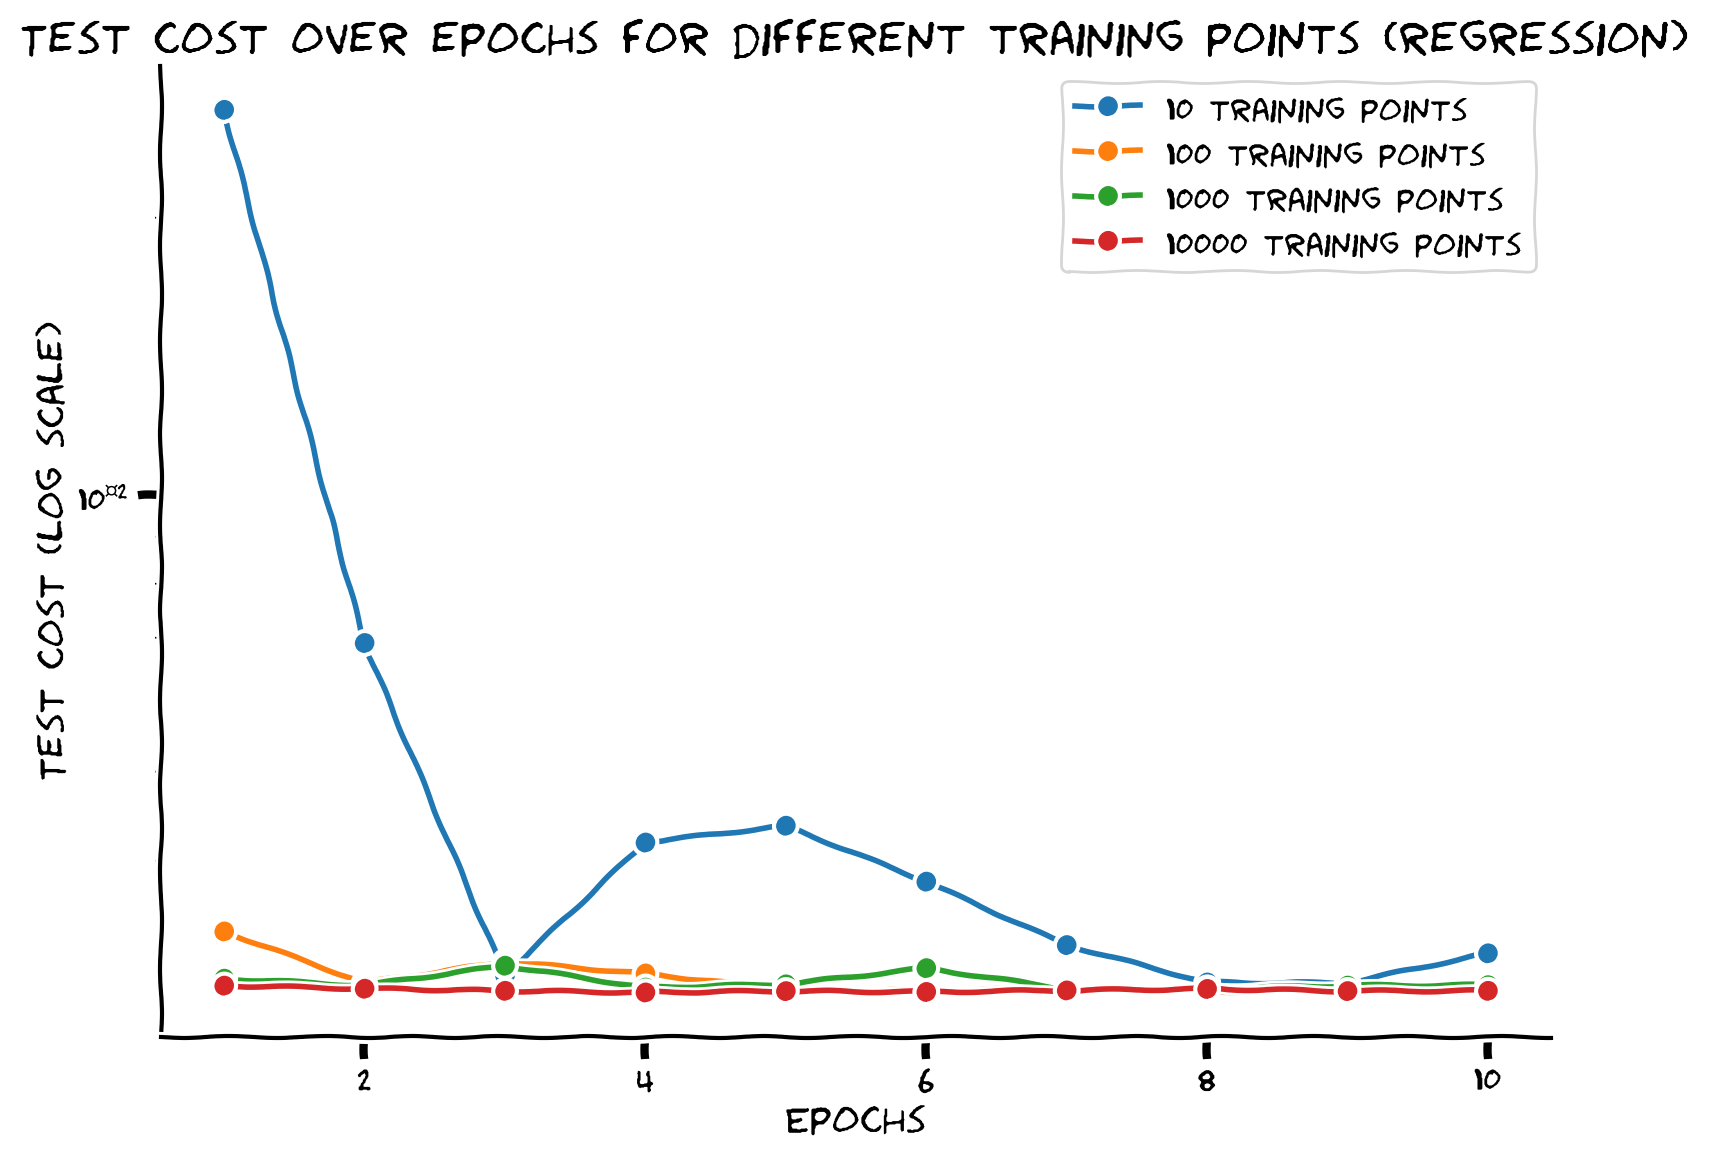

In [29]:
# Create a single plot for all test costs with a logarithmic scale

with plt.xkcd():
    plt.figure(figsize=(8, 6))  #Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Regression[i]
        test_cost = my_test_cost_Regression[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (regression)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_eb15e56d.py)



In [30]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_2")

## Section 1.3: Auto-encoder

Now, we extend our network architecture to an unsupervised learning task. Specifically, we aim to develop an autoencoder capable of compressing an image of a handwritten digit into a lower-dimensional representation of size $M$ and then reconstructing the original image with minimal error.

### Autoencoder architecture

An autoencoder consists of three main components: an encoder, a bottleneck layer, and a decoder. The encoder compresses the input into a smaller representation, the bottleneck layer holds this compressed representation, and the decoder reconstructs the original image from this representation.

In [31]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, bottleneck, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.bottleneck = bottleneck
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        bottlenecked = self.bottleneck(encoded)
        decoded = self.decoder(bottlenecked)
        return decoded

In our architecture:

* The encoder will be a CNN
* The bottleneck layer will be a fully connected layer of size $M$.
* The decoder layer will be a deconvolutional neural network, which does the operations of a CNN in reverse: it goes from a dense representation to a low-resolution image, and then upsamples that image in subsequence layers.

### Code exercise 3: Cost Function

We'll use Mean Squared Error (MSE) loss for the autoencoder. This loss function measures the average squared difference between the original and reconstructed images, guiding the network to minimize the reconstruction error.

In [32]:
def cost_autoencoder(output, target):
    ############################################################
    # Hint for output_flat: To flatten the output tensor for comparison, reshape it to
    # have a size of (batch_size, -1) where batch_size is the number of samples.
    # Hint for target_flat: Similarly, flatten the target tensor to match the shape
    # of the flattened output tensor, ensuring it has a size of (batch_size, -1).
    # raise NotImplementedError("Student exercise")
    ############################################################
    criterion = nn.MSELoss()
    output_flat = output.view(-1)
    target_flat = target.view(-1)
    cost = criterion(output_flat, target_flat)
    return cost

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_48232671.py)



In [33]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Cost_Function_3")

### Dataset

This custom dataset class prepares the MNIST images for the autoencoder task, applying necessary transformations and using the images themselves as targets for reconstruction.

In [34]:
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset

    def __getitem__(self, index):
        X, y = self.dataset[index]
        return X, X

    def __len__(self):
        return len(self.dataset)

### Model training and evaluation

We train separate autoencoder networks on different dataset sizes (10, 100, 1000, 10000) to analyze how the amount of data influences the model's performance. The training continues until the validation performance ceases to improve, and test performance is recorded at each epoch.

Note: we also plot here some of the original validation images and how they were reconstructed by each network after 10 iterations.

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.82655| Val cost:  0.93275| Test cost:  0.91777|
Saving the model: models/ConvNet_autoencoder_10_epoch_1.pth
Epoch: 2| Train cost:  0.82601| Val cost:  0.93241| Test cost:  0.91647|
Saving the model: models/ConvNet_autoencoder_10_epoch_2.pth
Epoch: 3| Train cost:  0.82552| Val cost:  0.93208| Test cost:  0.91641|
Saving the model: models/ConvNet_autoencoder_10_epoch_3.pth
Epoch: 4| Train cost:  0.82504| Val cost:  0.93175| Test cost:  0.91530|
Saving the model: models/ConvNet_autoencoder_10_epoch_4.pth
Epoch: 5| Train cost:  0.82457| Val cost:  0.93140| Test cost:  0.91583|
Saving the model: models/ConvNet_autoencoder_10_epoch_5.pth
Epoch: 6| Train cost:  0.82409| Val cost:  0.93102| Test cost:  0.91561|
Saving the model: models/ConvNet_autoencoder_10_epoch_6.pth
Epoch: 7| Train cost:  0.82359| Val cost:  0.93060| Test cost:  0.91493|
Saving the model: models/ConvNet_autoencoder_10_epoch_7.pth
Epoch: 8| Train cost:  0.82304| Val cost:  0.93011| Test cost:  0.914

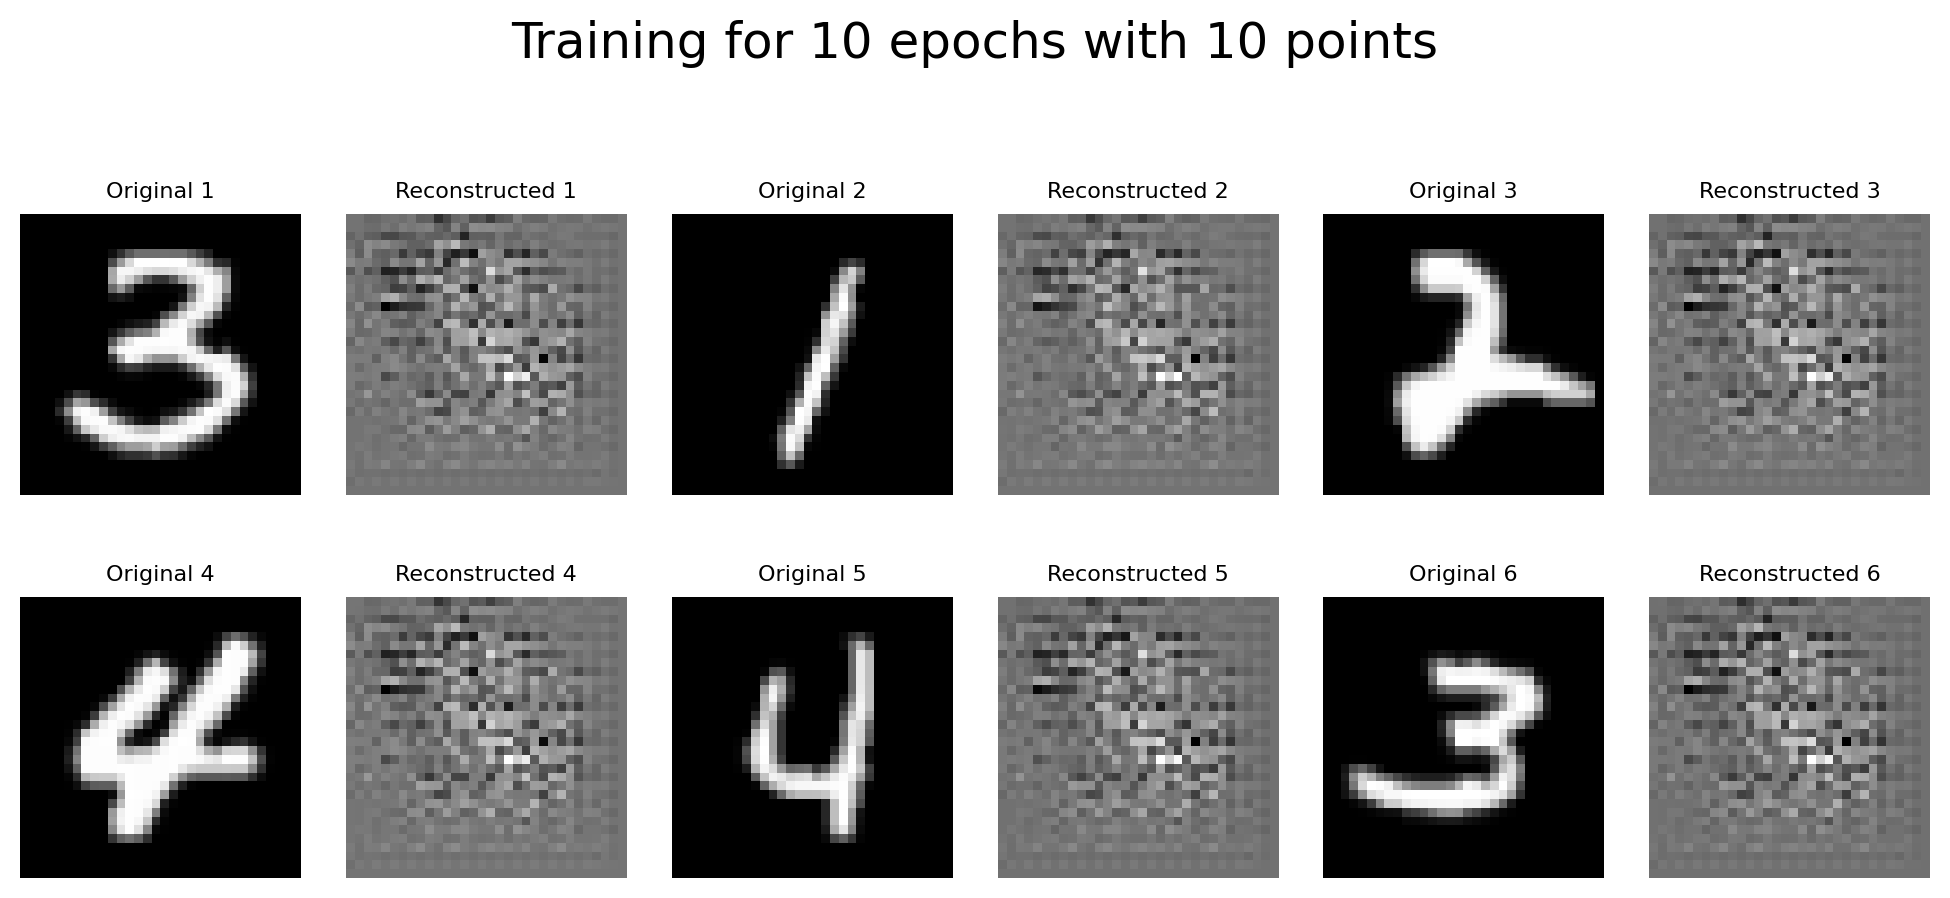

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.94496| Val cost:  1.09508| Test cost:  0.92759|
Saving the model: models/ConvNet_autoencoder_100_epoch_1.pth
Epoch: 2| Train cost:  0.84873| Val cost:  1.08896| Test cost:  0.92309|
Saving the model: models/ConvNet_autoencoder_100_epoch_2.pth
Epoch: 3| Train cost:  0.89585| Val cost:  1.08088| Test cost:  0.91713|
Saving the model: models/ConvNet_autoencoder_100_epoch_3.pth
Epoch: 4| Train cost:  0.89527| Val cost:  1.06307| Test cost:  0.90104|
Saving the model: models/ConvNet_autoencoder_100_epoch_4.pth
Epoch: 5| Train cost:  0.90988| Val cost:  0.99760| Test cost:  0.84872|
Saving the model: models/ConvNet_autoencoder_100_epoch_5.pth
Epoch: 6| Train cost:  0.80133| Val cost:  0.85810| Test cost:  0.75280|
Saving the model: models/ConvNet_autoencoder_100_epoch_6.pth
Epoch: 7| Train cost:  0.73808| Val cost:  0.82491| Test cost:  0.72001|
Saving the model: models/ConvNet_autoencoder_100_epoch_7.pth
Epoch: 8| Train cost:  0.67040| Val cost:  0.83882| Test cost:

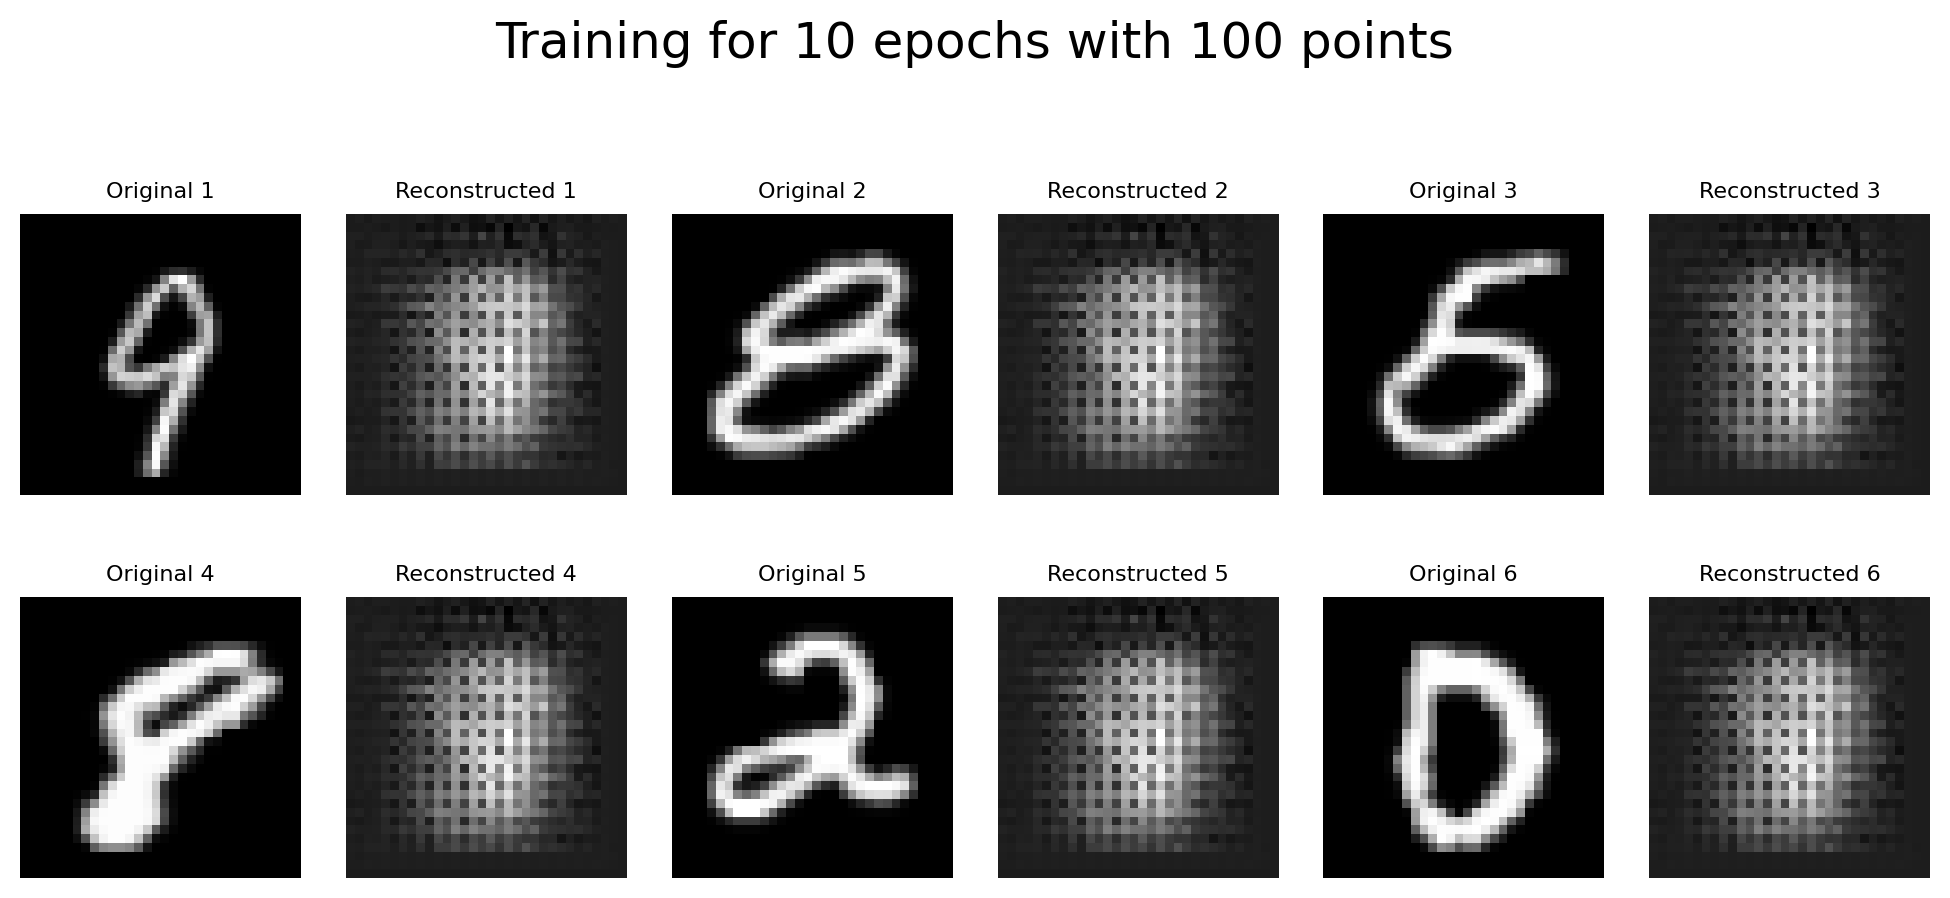

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.79917| Val cost:  0.67037| Test cost:  0.67448|
Saving the model: models/ConvNet_autoencoder_1000_epoch_1.pth
Epoch: 2| Train cost:  0.62655| Val cost:  0.61430| Test cost:  0.61073|
Saving the model: models/ConvNet_autoencoder_1000_epoch_2.pth
Epoch: 3| Train cost:  0.59072| Val cost:  0.59547| Test cost:  0.58791|
Saving the model: models/ConvNet_autoencoder_1000_epoch_3.pth
Epoch: 4| Train cost:  0.57190| Val cost:  0.58537| Test cost:  0.57857|
Saving the model: models/ConvNet_autoencoder_1000_epoch_4.pth
Epoch: 5| Train cost:  0.56552| Val cost:  0.56728| Test cost:  0.56702|
Saving the model: models/ConvNet_autoencoder_1000_epoch_5.pth
Epoch: 6| Train cost:  0.53808| Val cost:  0.54136| Test cost:  0.52821|
Saving the model: models/ConvNet_autoencoder_1000_epoch_6.pth
Epoch: 7| Train cost:  0.50795| Val cost:  0.51915| Test cost:  0.50817|
Saving the model: models/ConvNet_autoencoder_1000_epoch_7.pth
Epoch: 8| Train cost:  0.48034| Val cost:  0.47949| Tes

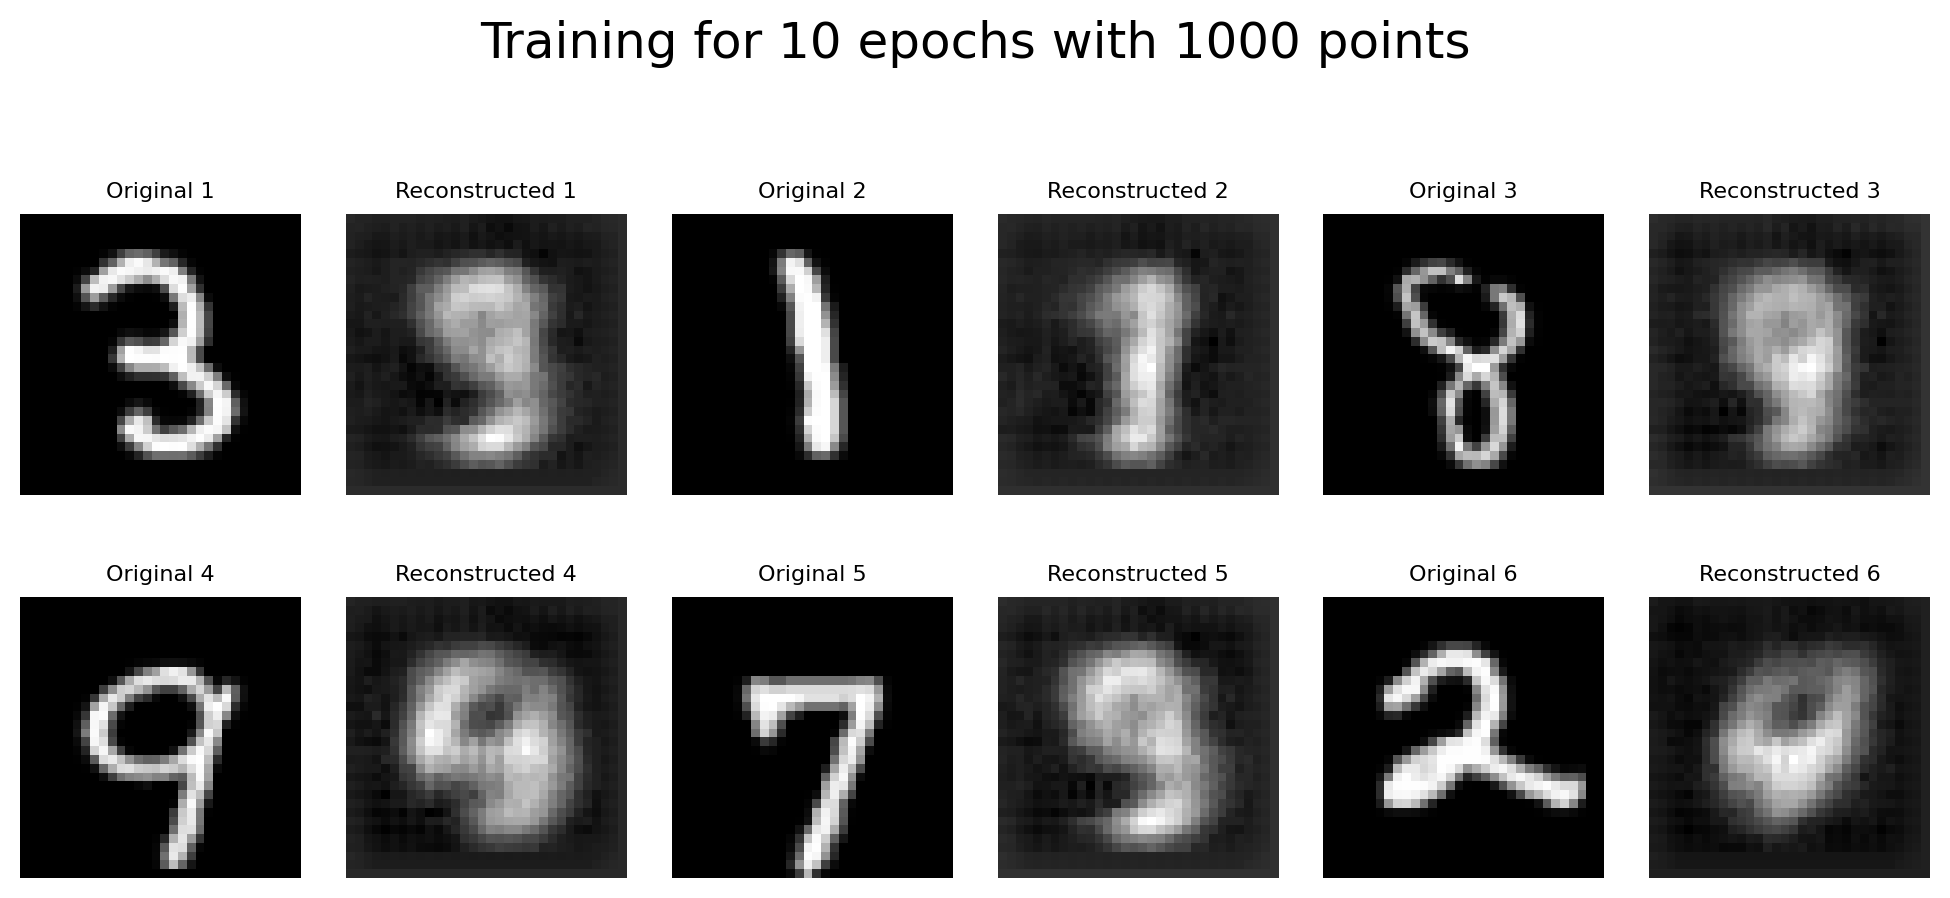

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.56576| Val cost:  0.41773| Test cost:  0.42167|
Saving the model: models/ConvNet_autoencoder_10000_epoch_1.pth
Epoch: 2| Train cost:  0.36431| Val cost:  0.30629| Test cost:  0.30257|
Saving the model: models/ConvNet_autoencoder_10000_epoch_2.pth
Epoch: 3| Train cost:  0.27457| Val cost:  0.24687| Test cost:  0.24363|
Saving the model: models/ConvNet_autoencoder_10000_epoch_3.pth
Epoch: 4| Train cost:  0.23165| Val cost:  0.21763| Test cost:  0.21321|
Saving the model: models/ConvNet_autoencoder_10000_epoch_4.pth
Epoch: 5| Train cost:  0.20834| Val cost:  0.20532| Test cost:  0.20038|
Saving the model: models/ConvNet_autoencoder_10000_epoch_5.pth
Epoch: 6| Train cost:  0.19651| Val cost:  0.19767| Test cost:  0.19145|
Saving the model: models/ConvNet_autoencoder_10000_epoch_6.pth
Epoch: 7| Train cost:  0.18809| Val cost:  0.19380| Test cost:  0.18814|
Saving the model: models/ConvNet_autoencoder_10000_epoch_7.pth
Epoch: 8| Train cost:  0.18166| Val cost:  0.187

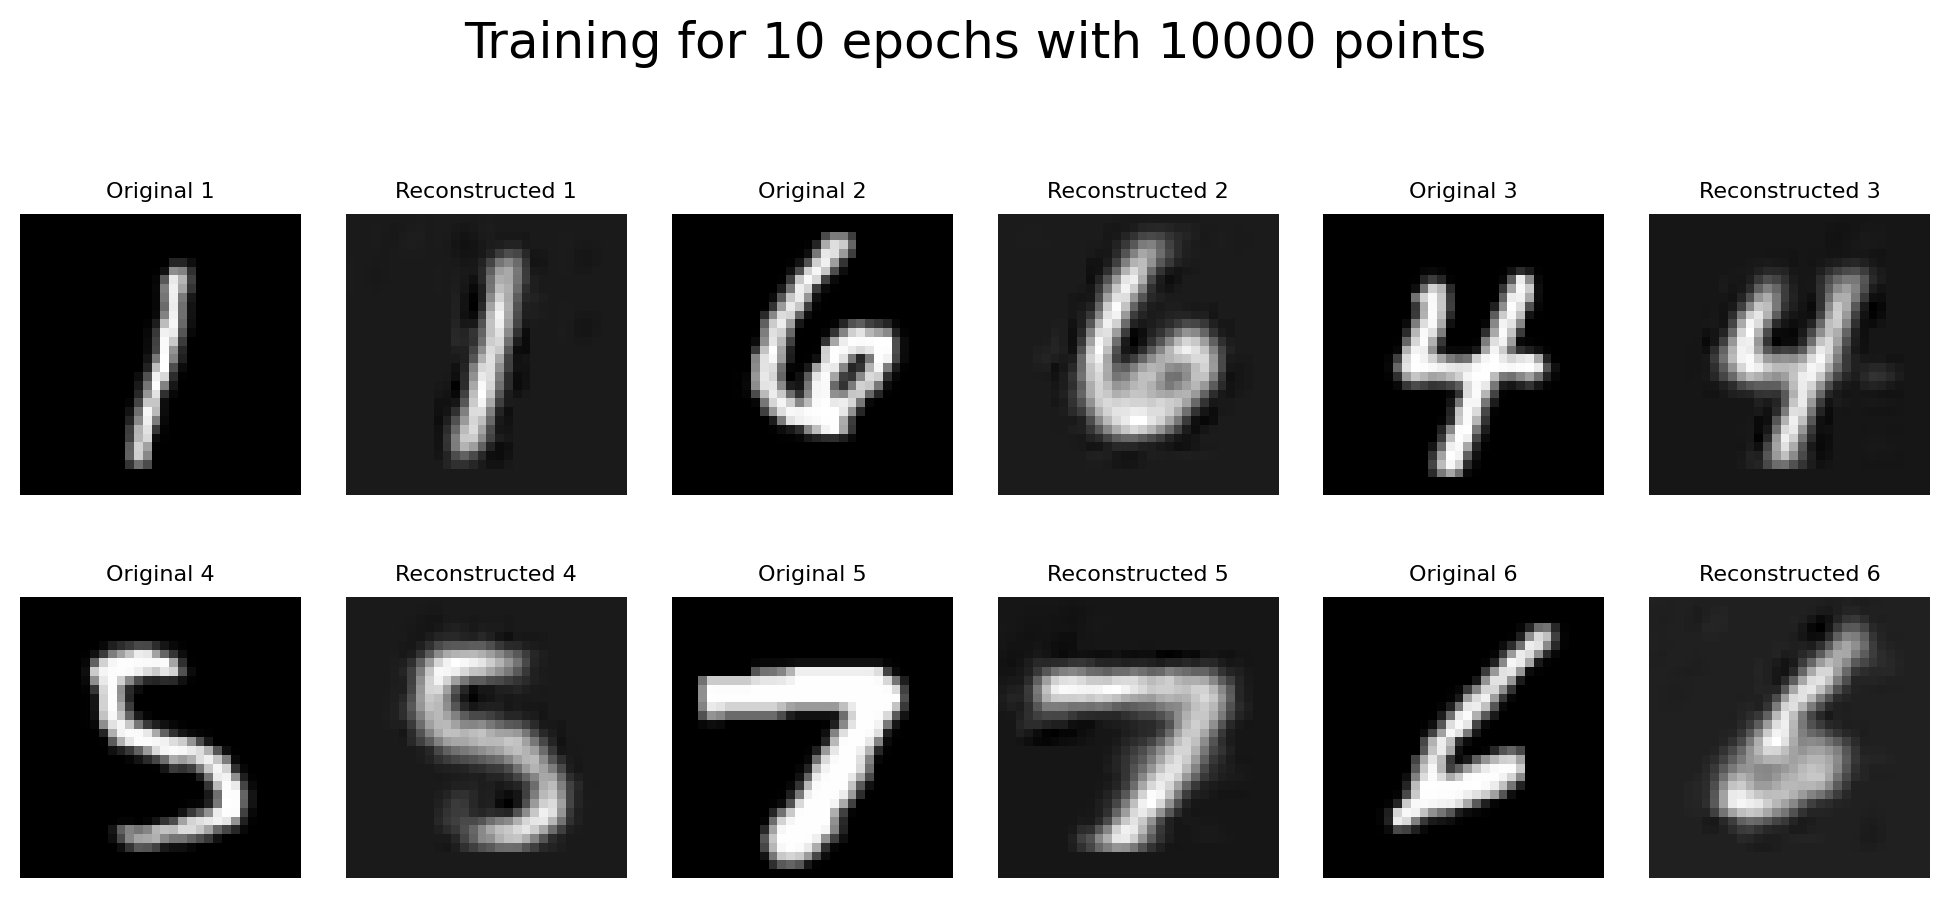

In [35]:
set_seed(42)

# Define constants for autoencoder task
training_points = np.array([10, 100, 1000, 10000])
task_name_autoencoder = "autoencoder"

# Size of the bottleneck. We'll keep this consistent across experiments.
M = 16
acc_flag_autoencoder = False
triplet_flag_autoencoder = False
epochs_max_autoencoder = 10

train_dataset_autoencoder = AutoencoderMNIST(train_dataset)
val_dataset_autoencoder = AutoencoderMNIST(val_dataset)
test_dataset_original_autoencoder = AutoencoderMNIST(test_dataset_original)
test_loader_original_autoencoder = torch.utils.data.DataLoader(
    dataset=test_dataset_original_autoencoder,
    batch_size=batch_size,
    shuffle=True
)

for N_train_data in training_points:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(
        train_dataset_autoencoder,
        val_dataset_autoencoder,
        batch_size,
        N_train_data
    )
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(
        model,
        sampled_train_loader,
        sampled_val_loader,
        test_loader_original_autoencoder,
        cost_autoencoder,
        optimizer,
        epochs_max_autoencoder,
        acc_flag_autoencoder,
        triplet_flag_autoencoder,
        task_name_autoencoder,
        N_train_data
    )
    if N_train_data == 10:
        my_epoch_Autoencoder = [my_epoch]
        my_train_cost_Autoencoder = [my_train_cost] # Add a list to store training costs
        my_val_cost_Autoencoder = [my_val_cost] # Add a list to store val costs
        my_test_cost_Autoencoder = [my_test_cost] # Add a list to store test costs
    else:
        my_epoch_Autoencoder.append(my_epoch)
        my_train_cost_Autoencoder.append(my_train_cost)
        my_val_cost_Autoencoder.append(my_val_cost)
        my_test_cost_Autoencoder.append(my_test_cost)

    original_images = []
    reconstructed_images = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, _) in enumerate(sampled_val_loader):
            if batch_idx == 0:
                outputs = model(X)
                orig = X.numpy()
                original_images.extend(orig)
                recon = outputs.numpy()
                reconstructed_images.extend(recon)
                plot_reconstructions(original_images, reconstructed_images, N_train_data, epochs_max_autoencoder)
                break

    if N_train_data == 10:
        reconstructions = [(N_train_data, original_images, reconstructed_images)] # List to store original and reconstructed images
    else:
        reconstructions.append((N_train_data, original_images, reconstructed_images))

### Discussion point 3

- Plot the performance of the network across epochs. What's the relationship between sample size and iteration complexity?
- What do you think of the images plotted above? Does the autoencoding task require more or less data than the two previous tasks (classification of digit and regression of number of ON pixels)?


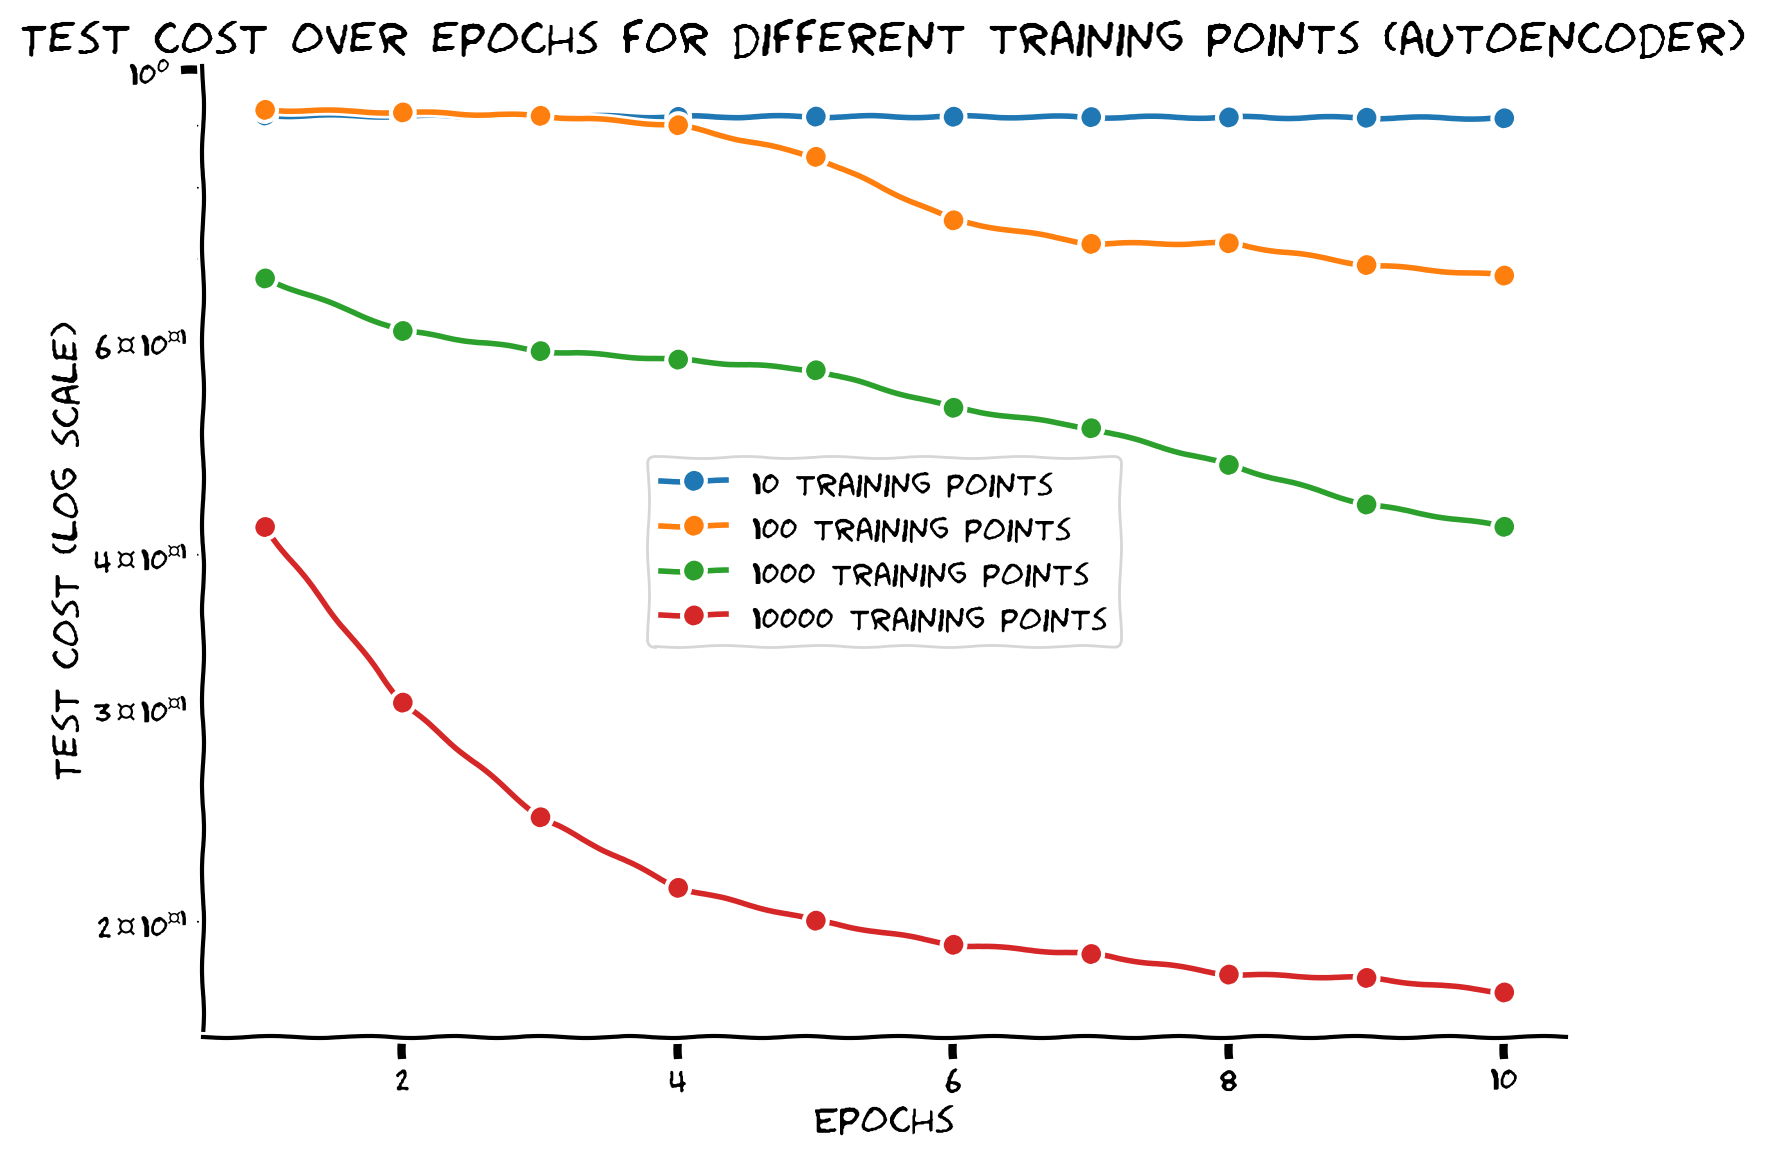

In [36]:
# Create a single plot for all test costs with a logarithmic scale

with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Autoencoder[i]
        test_cost = my_test_cost_Autoencoder[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (autoencoder)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_e18cfe86.py)



In [37]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_3")

## Section 1.4: Self-supervised - Inpainting

In this section, we tackle a self-supervised task using the same architecture. Given an image of a handwritten digit with a patch of size $N×N$ masked out, the objective is to reconstruct the image by accurately predicting the pixel values in the masked region. Thus, the network must use the surrounding context to effectively "inpaint" the missing portion.

### Task objective

The task is to build an autoencoder that can fill in missing parts of an image, a process known as inpainting. This involves training the model to reconstruct the entire image. Implicitely, the model will predict and reconstruct the obstructed regions of the image using the contextual information from the unobstructed parts.

Important note: this is a simplified inpainting task and not how inpainting is usually define. Usually, the region to be inpainted is provided as part of the input.

### Random masking

First, we implement a function to randomly mask a part of the image. This function will be used to generate the training data for our inpainting task.

In [38]:
def random_mask(images, mask_size=8):
    """
    Randomly mask an N x N patch in a batch of images.

    Parameters:
    - images: A batch of images as a PyTorch tensor, shape (batch_size, channels, height, width)
    - mask_size: Size of the square mask (N)

    Returns:
    - A new batch of images with the masked portions zeroed out.
    """
    # Clone the images to avoid modifying the original data
    obstructed_images = images.clone()

    batch_size, height, width = images.size()

    for i in range(batch_size):
        # Choose a random location for the mask
        y = np.random.randint(0, height - mask_size)
        x = np.random.randint(0, width - mask_size)

        # Apply the mask by setting the pixel values to 0 (or another value)
        obstructed_images[i, y:y + mask_size, x:x + mask_size] = 0

    return obstructed_images

Here's one example of a masked image.

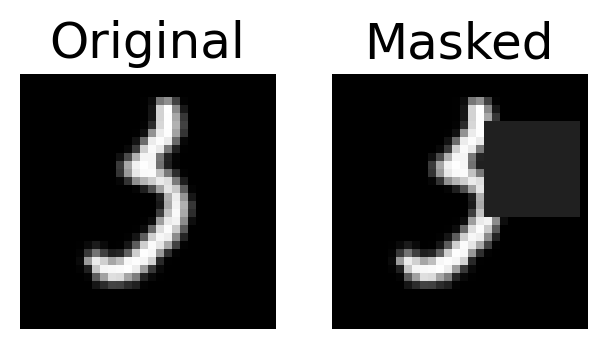

In [39]:
plt.figure(figsize=(4, 2))
ind = 12
img, label = train_dataset[ind]
plt.subplot(121)
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.title(f"Original")
plt.axis(False)
plt.tight_layout()
plt.subplot(122)
img_masked = random_mask(img, mask_size=12)
plt.imshow(img_masked.numpy().squeeze(), cmap='gray')
plt.title(f"Masked")
plt.axis(False)
plt.tight_layout()

This function randomly places a N×N mask in each image by setting the pixel values within this region to zero.

### Autoencoder and cost function

We re-use the same autoencoder architecture as in the previous sections, with an encoder, bottleneck layer, and decoder. We also use the Mean Squared Error (MSE) loss, as it measures the reconstruction error between the predicted and actual pixel values.

### Dataset

This custom dataset class prepares the MNIST images for the inpainting task, applying necessary transformations and adding random masking to create the training data.

In [40]:
class InpaintingMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.dataset = mnist_dataset

    def __getitem__(self, index):
        X, y = self.dataset[index]
        obstructed = random_mask(X, mask_size=8)
        return obstructed, X

    def __len__(self):
        return len(self.dataset)

### Model training and evaluation

We train the autoencoder on different dataset sizes (10, 100, 1000, 10000) to evaluate how the sample size affects the model's performance. Training continues until validation performance stops improving, and test performance is recorded at each epoch.

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.82655| Val cost:  0.93275| Test cost:  0.91777|
Saving the model: models/ConvNet_inpainting_10_epoch_1.pth
Epoch: 2| Train cost:  0.82601| Val cost:  0.93241| Test cost:  0.91647|
Saving the model: models/ConvNet_inpainting_10_epoch_2.pth
Epoch: 3| Train cost:  0.82552| Val cost:  0.93208| Test cost:  0.91641|
Saving the model: models/ConvNet_inpainting_10_epoch_3.pth
Epoch: 4| Train cost:  0.82504| Val cost:  0.93175| Test cost:  0.91530|
Saving the model: models/ConvNet_inpainting_10_epoch_4.pth
Epoch: 5| Train cost:  0.82457| Val cost:  0.93140| Test cost:  0.91583|
Saving the model: models/ConvNet_inpainting_10_epoch_5.pth
Epoch: 6| Train cost:  0.82409| Val cost:  0.93103| Test cost:  0.91561|
Saving the model: models/ConvNet_inpainting_10_epoch_6.pth
Epoch: 7| Train cost:  0.82359| Val cost:  0.93061| Test cost:  0.91493|
Saving the model: models/ConvNet_inpainting_10_epoch_7.pth
Epoch: 8| Train cost:  0.82305| Val cost:  0.93013| Test cost:  0.91441|
Sav

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.94496| Val cost:  1.09508| Test cost:  0.92759|
Saving the model: models/ConvNet_inpainting_100_epoch_1.pth
Epoch: 2| Train cost:  0.84873| Val cost:  1.08895| Test cost:  0.92308|
Saving the model: models/ConvNet_inpainting_100_epoch_2.pth
Epoch: 3| Train cost:  0.89581| Val cost:  1.08073| Test cost:  0.91698|
Saving the model: models/ConvNet_inpainting_100_epoch_3.pth
Epoch: 4| Train cost:  0.89478| Val cost:  1.06119| Test cost:  0.89939|
Saving the model: models/ConvNet_inpainting_100_epoch_4.pth
Epoch: 5| Train cost:  0.90555| Val cost:  0.98824| Test cost:  0.84085|
Saving the model: models/ConvNet_inpainting_100_epoch_5.pth
Epoch: 6| Train cost:  0.79199| Val cost:  0.86862| Test cost:  0.76460|
Saving the model: models/ConvNet_inpainting_100_epoch_6.pth
Epoch: 7| Train cost:  0.73877| Val cost:  0.82494| Test cost:  0.71873|
Saving the model: models/ConvNet_inpainting_100_epoch_7.pth
Epoch: 8| Train cost:  0.67005| Val cost:  0.83807| Test cost:  0.719

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.79506| Val cost:  0.67492| Test cost:  0.67748|
Saving the model: models/ConvNet_inpainting_1000_epoch_1.pth
Epoch: 2| Train cost:  0.62760| Val cost:  0.61575| Test cost:  0.61304|
Saving the model: models/ConvNet_inpainting_1000_epoch_2.pth
Epoch: 3| Train cost:  0.59319| Val cost:  0.59748| Test cost:  0.59038|
Saving the model: models/ConvNet_inpainting_1000_epoch_3.pth
Epoch: 4| Train cost:  0.57480| Val cost:  0.58742| Test cost:  0.58225|
Saving the model: models/ConvNet_inpainting_1000_epoch_4.pth
Epoch: 5| Train cost:  0.57000| Val cost:  0.57417| Test cost:  0.57503|
Saving the model: models/ConvNet_inpainting_1000_epoch_5.pth
Epoch: 6| Train cost:  0.56177| Val cost:  0.56145| Test cost:  0.55548|
Saving the model: models/ConvNet_inpainting_1000_epoch_6.pth
Epoch: 7| Train cost:  0.53659| Val cost:  0.54408| Test cost:  0.53667|
Saving the model: models/ConvNet_inpainting_1000_epoch_7.pth
Epoch: 8| Train cost:  0.52694| Val cost:  0.53012| Test cost:

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  0.58190| Val cost:  0.47478| Test cost:  0.47997|
Saving the model: models/ConvNet_inpainting_10000_epoch_1.pth
Epoch: 2| Train cost:  0.42325| Val cost:  0.36276| Test cost:  0.36143|
Saving the model: models/ConvNet_inpainting_10000_epoch_2.pth
Epoch: 3| Train cost:  0.31277| Val cost:  0.28690| Test cost:  0.28382|
Saving the model: models/ConvNet_inpainting_10000_epoch_3.pth
Epoch: 4| Train cost:  0.27264| Val cost:  0.26621| Test cost:  0.26298|
Saving the model: models/ConvNet_inpainting_10000_epoch_4.pth
Epoch: 5| Train cost:  0.25592| Val cost:  0.25603| Test cost:  0.25233|
Saving the model: models/ConvNet_inpainting_10000_epoch_5.pth
Epoch: 6| Train cost:  0.24281| Val cost:  0.23813| Test cost:  0.23480|
Saving the model: models/ConvNet_inpainting_10000_epoch_6.pth
Epoch: 7| Train cost:  0.23076| Val cost:  0.23093| Test cost:  0.22796|
Saving the model: models/ConvNet_inpainting_10000_epoch_7.pth
Epoch: 8| Train cost:  0.22277| Val cost:  0.22408| Tes

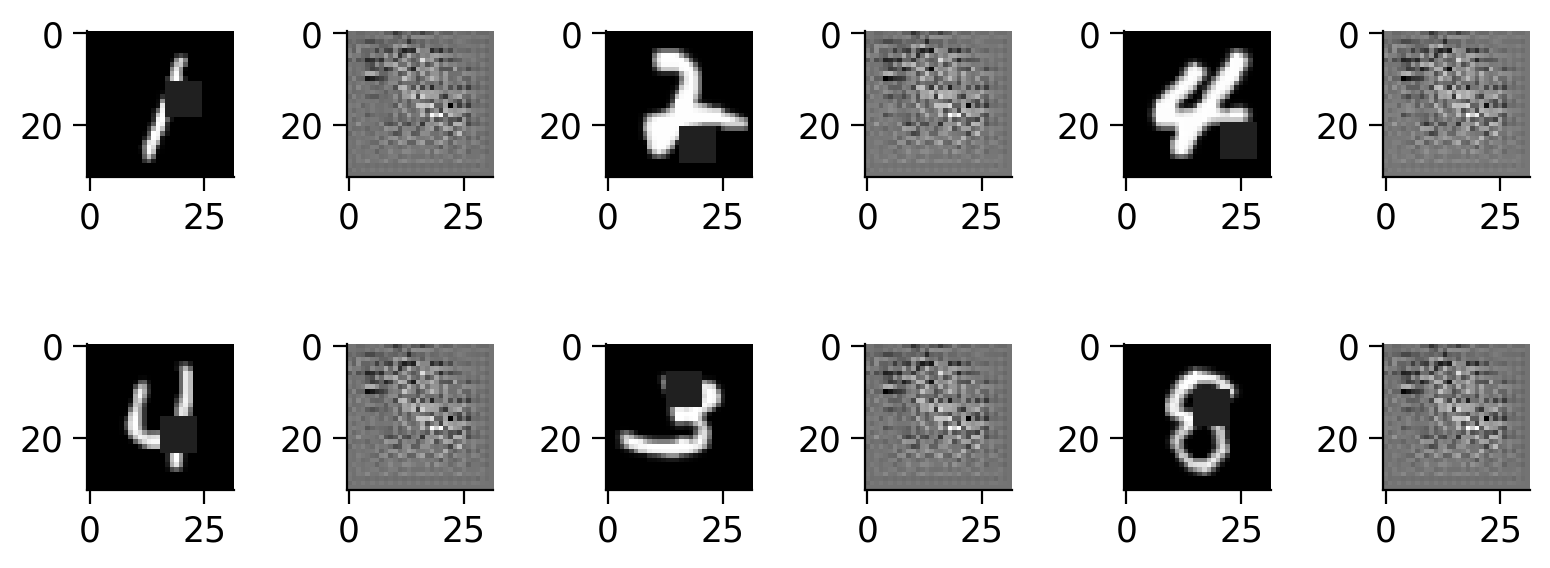

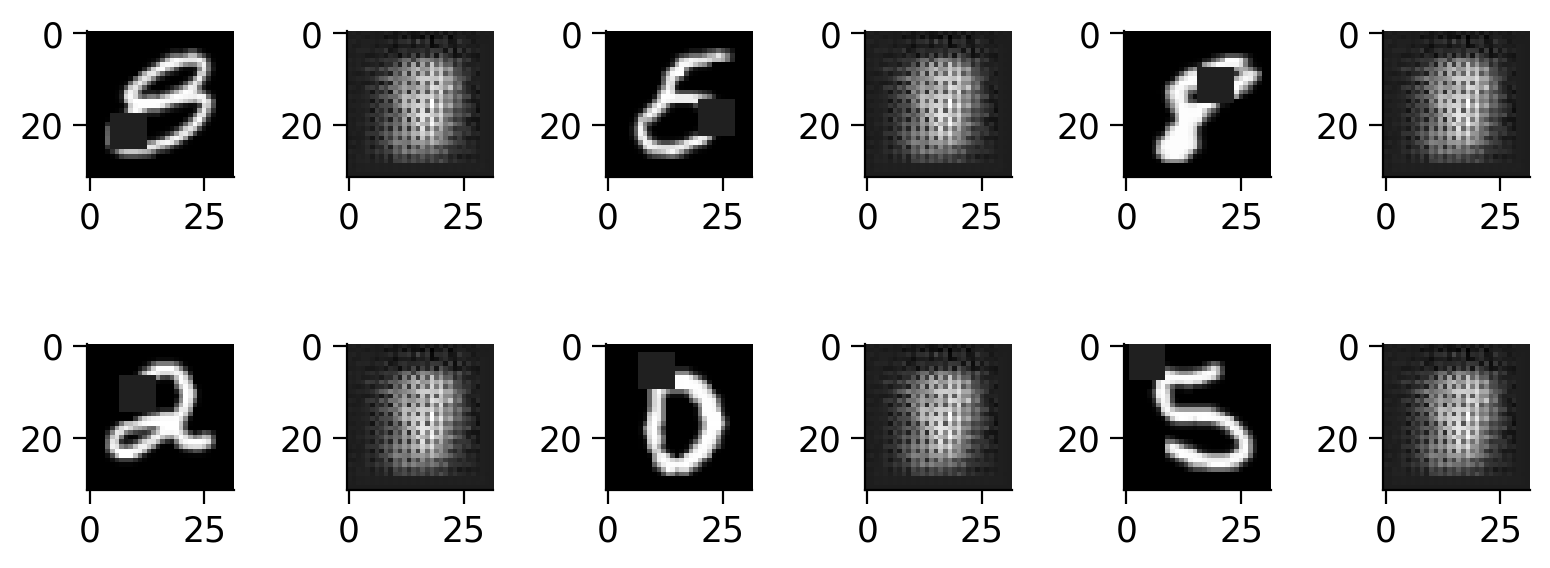

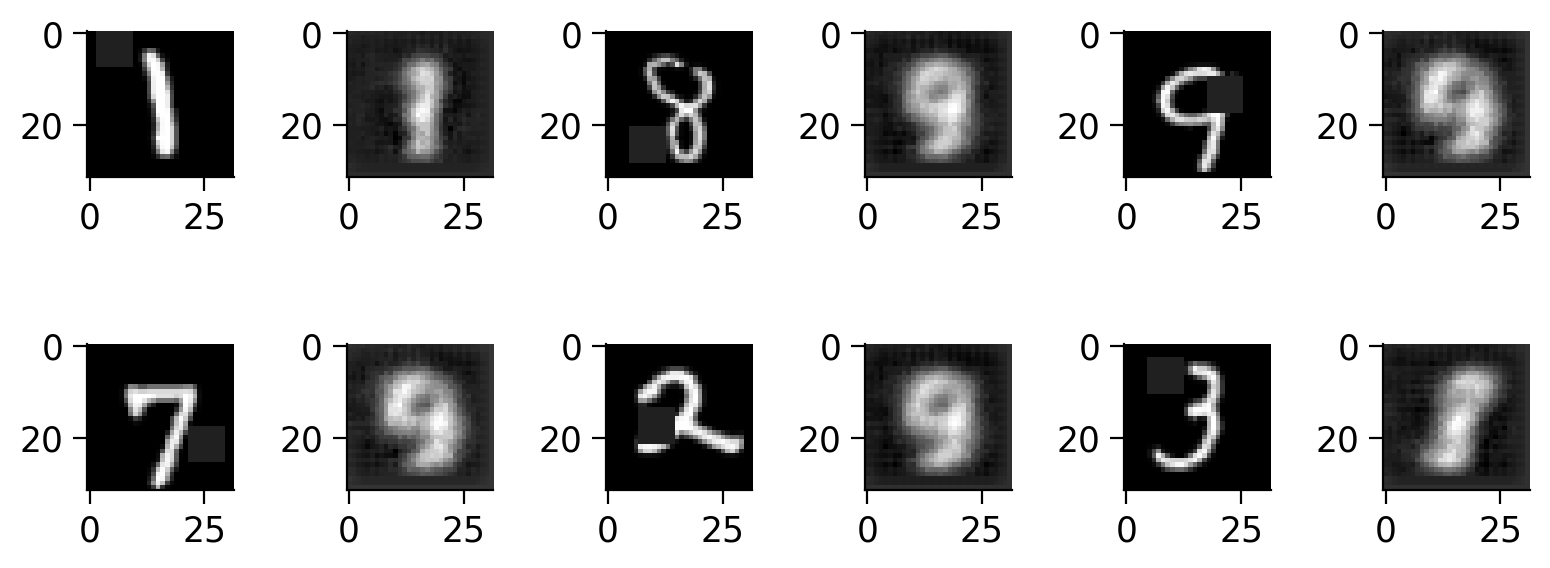

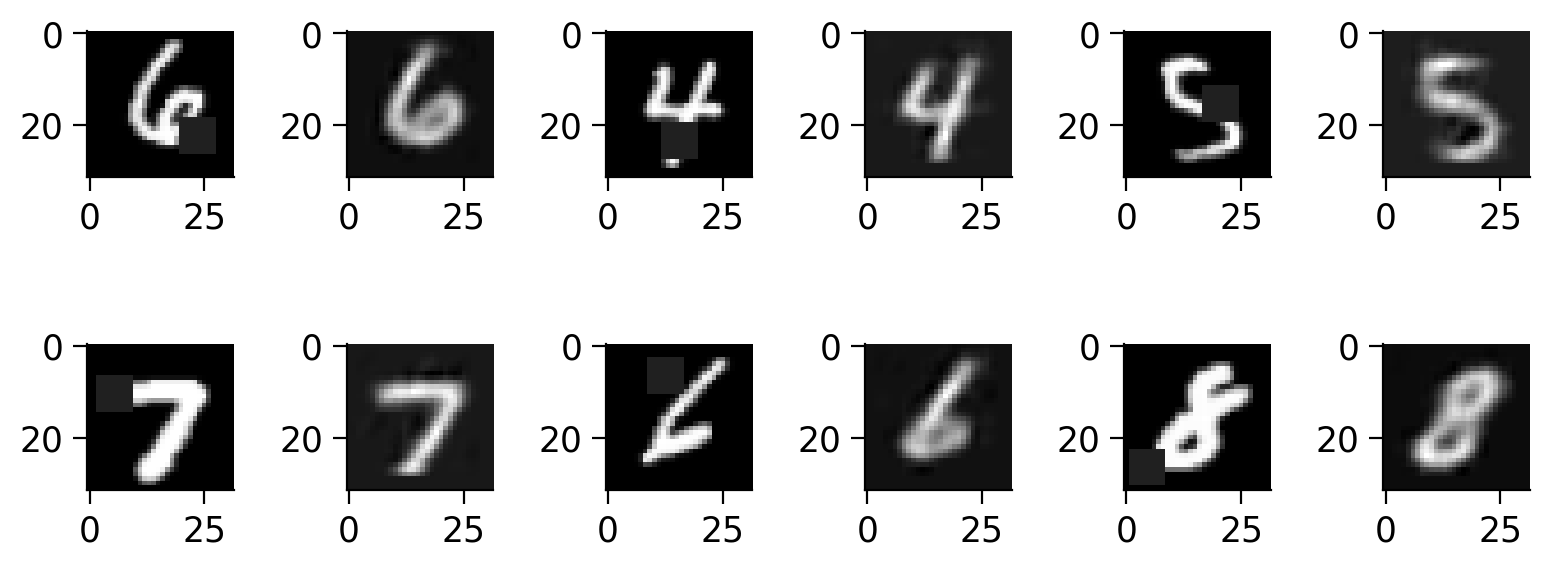

In [41]:
# Define constants
set_seed(42)

training_points = np.array([10, 100, 1000, 10000])
task_name_inpainting = "inpainting"

acc_flag_inpainting = False
triplet_flag_inpainting = False
epochs_max_inpainting = 10

# Create inpainting versions of the training, validation, and test datasets
train_dataset_inpainting = InpaintingMNIST(train_dataset)
val_dataset_inpainting = InpaintingMNIST(val_dataset)
test_dataset_original_inpainting = InpaintingMNIST(test_dataset_original)

# Create a data loader for the inpainting test dataset
test_loader_original_inpainting = torch.utils.data.DataLoader(
    dataset=test_dataset_original_inpainting,
    batch_size=batch_size,
    shuffle=True
)

for N_train_data in training_points:
    model = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

    sampled_train_loader, sampled_val_loader = get_random_sample_train_val(
        train_dataset_inpainting,
        val_dataset_inpainting,
        batch_size,
        N_train_data
    )
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    # Update the train function call to get training costs
    my_epoch, my_train_cost, my_val_cost, my_test_cost = train(
        model,
        sampled_train_loader,
        sampled_val_loader,
        test_loader_original_inpainting,
        cost_autoencoder,
        optimizer,
        epochs_max_inpainting,
        acc_flag_inpainting,
        triplet_flag_inpainting,
        task_name_inpainting,
        N_train_data
    )
    # Initialize lists to store training epochs and test costs for the inpainting task
    if N_train_data == 10:
        my_epoch_Inpainting = [my_epoch]
        my_train_cost_Inpainting = [my_train_cost]  # Add a list to store training costs
        my_val_cost_Inpainting = [my_val_cost] # Add a list to store val costs
        my_test_cost_Inpainting = [my_test_cost]  # Add a list to store test costs
    else:
        my_epoch_Inpainting.append(my_epoch)
        my_train_cost_Inpainting.append(my_train_cost)  # Append the training costs
        my_val_cost_Inpainting.append(my_val_cost)  # Append the training costs
        my_test_cost_Inpainting.append(my_test_cost)  # Append the training costs
    original_images = []
    reconstructed_images = []
    model.eval()
    with torch.no_grad():
      for batch_idx, (X, _) in enumerate(sampled_val_loader):
          if batch_idx == 0:  # Only visualize the first batch for simplicity
              outputs = model(X)
              orig = X.numpy()
              original_images.extend(orig)
              recon = outputs.numpy()
              reconstructed_images.extend(recon)
              fig = plt.figure(figsize=(8, 4))
              rows, cols = 2, 6
              image_count = 1
              for i in range(1,(rows*cols),2 ):
                  fig.add_subplot(rows, cols, i)
                  plt.imshow(np.squeeze(orig[image_count]), cmap='gray')
                  fig.add_subplot(rows, cols, i+1)
                  plt.imshow(np.squeeze(recon[image_count]), cmap='gray')
                  image_count+=1
              break
              plt.suptitle("Training for 10 epochs with {} points".format(N_train_data))

    if N_train_data == 10:
        reconstructions_inpainting = [(N_train_data, original_images, reconstructed_images)]
    else:
        reconstructions_inpainting.append((N_train_data, original_images, reconstructed_images))  # Store the original and reconstructed images

### Discussion point 4

- Plot the performance of the model on the test dataset for each network across epochs. What's the relationship between sample size and number of training epochs?
- How do these compare with the other examples above?

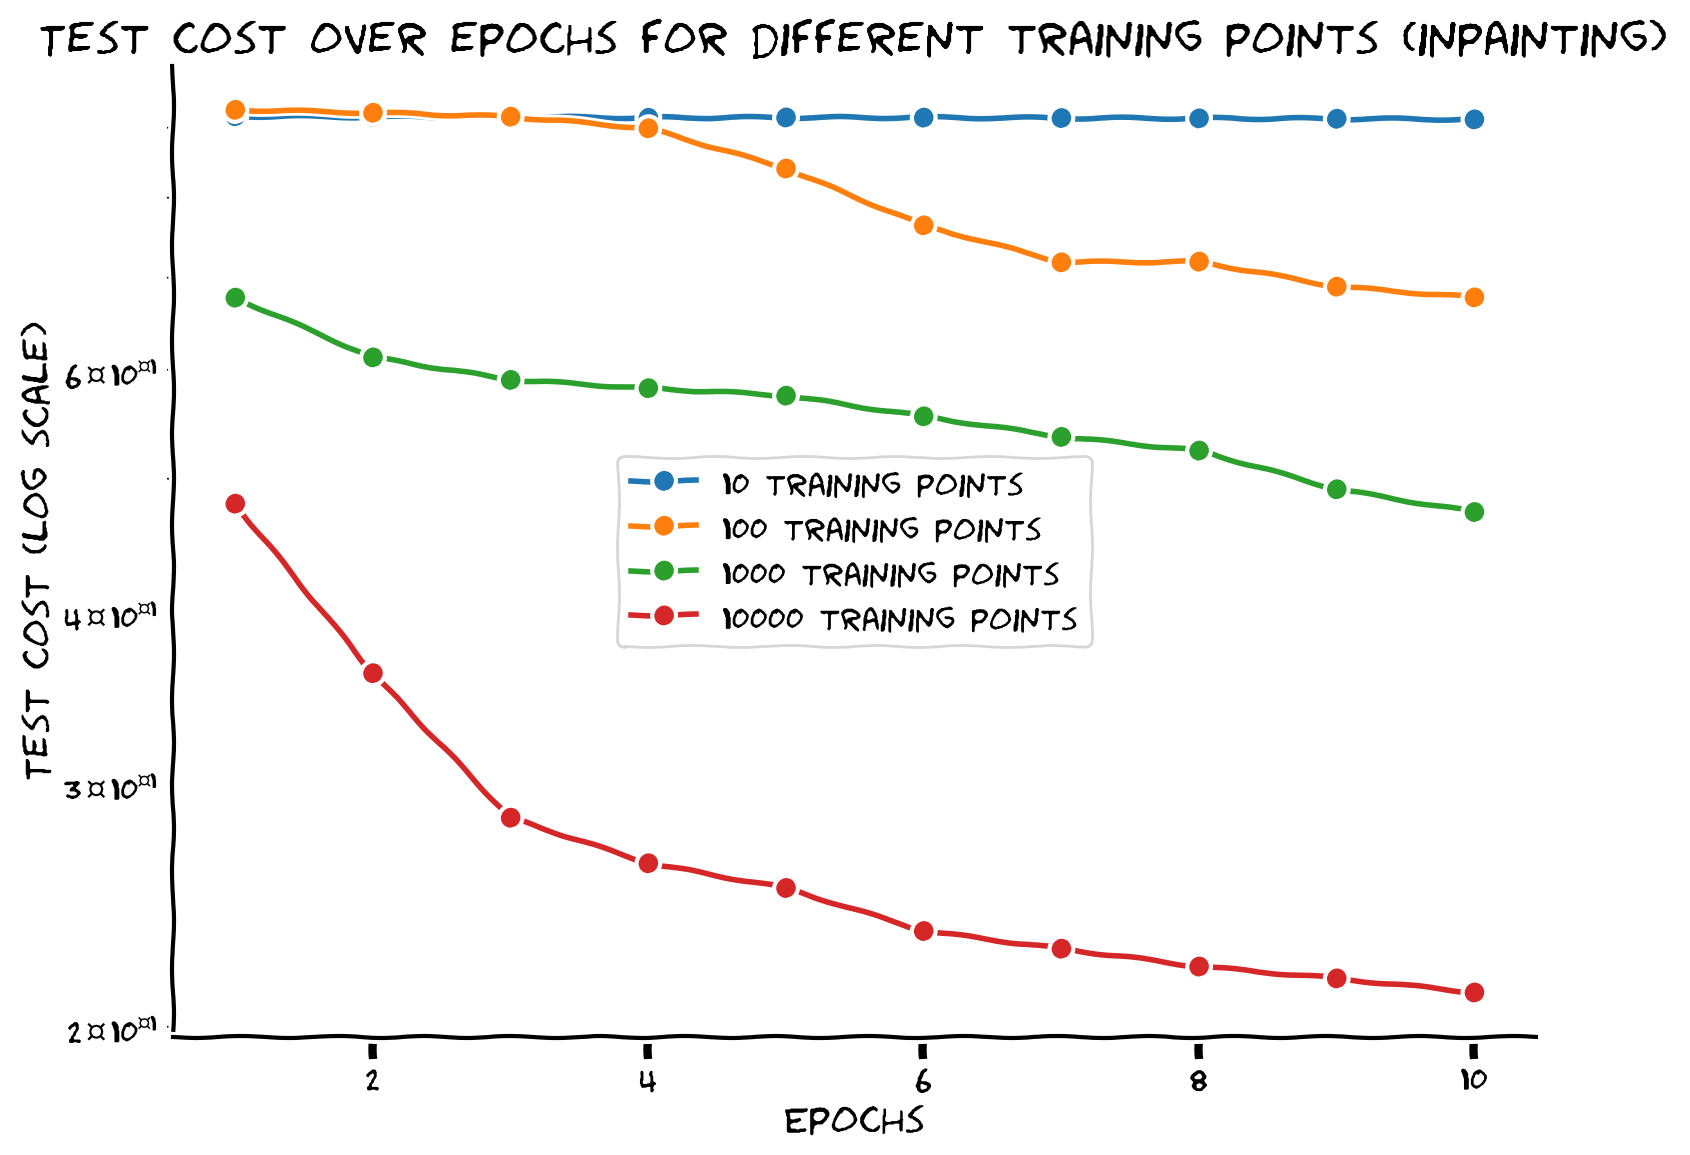

In [42]:
# Create a single plot for all test costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    for i, n in enumerate(training_points):
        epochs = my_epoch_Inpainting[i]
        test_cost = my_test_cost_Inpainting[i]
        plt.plot(epochs, test_cost, marker='o', linestyle='-', label=f'{n} training points')

    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs for different training points (inpainting)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_9836554e.py)



In [43]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_5")

---
# Section 2: Generalization of representations

In the first part of this tutorial, we focused on training different networks on different tasks, measuring how fast these networks learned in terms of training samples and training epochs. Here, we shift our attention to how well these representations generalize across different tasks.

## Section 2.1: Transfer

### Taskonomy

Humans can perform a wide range of tasks. The representations within this system must be general enough to handle multiple tasks, yet specific enough to accommodate differing requirements. We assess the ability of the representations we have learned to perform different tasks by testing generalization from one model to another.

### Transfer learning

We'll measure the ability of a representation learned for one task to transfer to other tasks. For each of the four tasks, we'll use the network trained for the highest number of training points and epochs. A new test set will be provided for each task. To test generalization, we follow these steps:

1. Create a new network for the destination task using the same architecture as in part 1.
2. Copy the weights for the first N layers from the source network.
3. Fix these copied weights so they do not change during training.
4. Train the remaining layers on the destination network.

After training, we'll compare the new performance to the original performance to assess transfer performance between each pair of networks.

Because we have N=4 different models, we could measure $2*(N-1)*(N-2)=12$ transfer directions. In the interest of time, we'll concentrate on measuring 3 transfer performances from the last 3 models to the classification model.

### Copy weights

We start by defining a function to copy the weights and freeze the layers from the source model to the destination model.

In [44]:
def copy_and_freeze_layers(source_model, destination_model, N):
    """
    Copies the weights of the first N layers from the source model to the
    destination model and freezes them.

    Parameters:
    - source_model: The model from which weights are copied.
    - destination_model: The model to which weights are copied and trained.
    - N: The number of layers to transfer and freeze.

    Note: This function assumes the first N layers are directly accessible and
    does not handle nested modules automatically.
    """

    # Ensure both models are in the same mode (train/eval).
    source_model.eval()
    destination_model.train()

    # Counter to track the number of transferred layers
    transferred_layers = 0

    source_dict = source_model.state_dict()
    dest_dict = destination_model.state_dict()

    # Variables to map between layers
    source_prefix = list(source_dict.keys())[0]
    source_prefix = source_prefix[:source_prefix.find('.')]
    source_dict_names = [s[s.find('.')+1:] for s in list(source_dict.keys())]
    dest_prefix = list(dest_dict.keys())[0]
    dest_prefix = dest_prefix[:dest_prefix.find('.')]
    dest_dict_names = [s[s.find('.')+1:] for s in list(dest_dict.keys())]
    print(dest_dict_names)

    # Transfer layers by matching keys
    for name in source_dict_names:
        if name in dest_dict_names and transferred_layers < N:
            try:
                dest_dict[dest_prefix+'.'+name].copy_(source_dict[source_prefix+'.'+name])
                transferred_layers += 1
                print(f"Copied {name}")
            except Exception as e:
                print(f"Could not copy {name}: {e}")

    # Load the updated state dictionary back to the destination model
    destination_model.load_state_dict(dest_dict)
    print(transferred_layers)
    # Freeze the transferred layers
    for name, param in destination_model.named_parameters():
        if name[name.find('.')+1:] in source_dict_names and transferred_layers > 0:
            print('froze ',name)
            param.requires_grad = False
            transferred_layers -= 1

    print(f"Copied and froze {N} layers.")

### Transfer example 1: regression to classification



We first copy the weights from a regression network to a classification network and freeze them.

In [45]:
MODEL_NAME_SOURCE = "models/ConvNet_regression_10000_epoch_10.pth"
model_source = RegressionConvNet(ConvNeuralNet(), RegressionOutputLayer())

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model
model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


#### Training

We train the destination network on the classification task with the transferred weights.

In [46]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "regression_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer1, my_train_cost_transfer1, my_val_cost_transfer1, my_test_cost_transfer1 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.30214| Val cost:  2.30180| Test cost:  2.30171|
Saving the model: models/ConvNet_regression_classification_10000_epoch_1.pth
Epoch: 2| Train cost:  2.30146| Val cost:  2.30126| Test cost:  2.30091|
Saving the model: models/ConvNet_regression_classification_10000_epoch_2.pth
Epoch: 3| Train cost:  2.30075| Val cost:  2.30075| Test cost:  2.30017|
Saving the model: models/ConvNet_regression_classification_10000_epoch_3.pth
Epoch: 4| Train cost:  2.29997| Val cost:  2.30013| Test cost:  2.29934|
Saving the model: models/ConvNet_regression_classification_10000_epoch_4.pth
Epoch: 5| Train cost:  2.29901| Val cost:  2.29937| Test cost:  2.29811|
Saving the model: models/ConvNet_regression_classification_10000_epoch_5.pth
Epoch: 6| Train cost:  2.29825| Val cost:  2.29853| Test cost:  2.29748|
Saving the model: models/ConvNet_regression_classification_10000_epoch_6.pth
Epoch: 7| Train cost:  2.29732| Val cost:  2.29719| Test cost:  2.29623|
Saving the model: models/Co

We compare the performance of the transferred model with the original network.

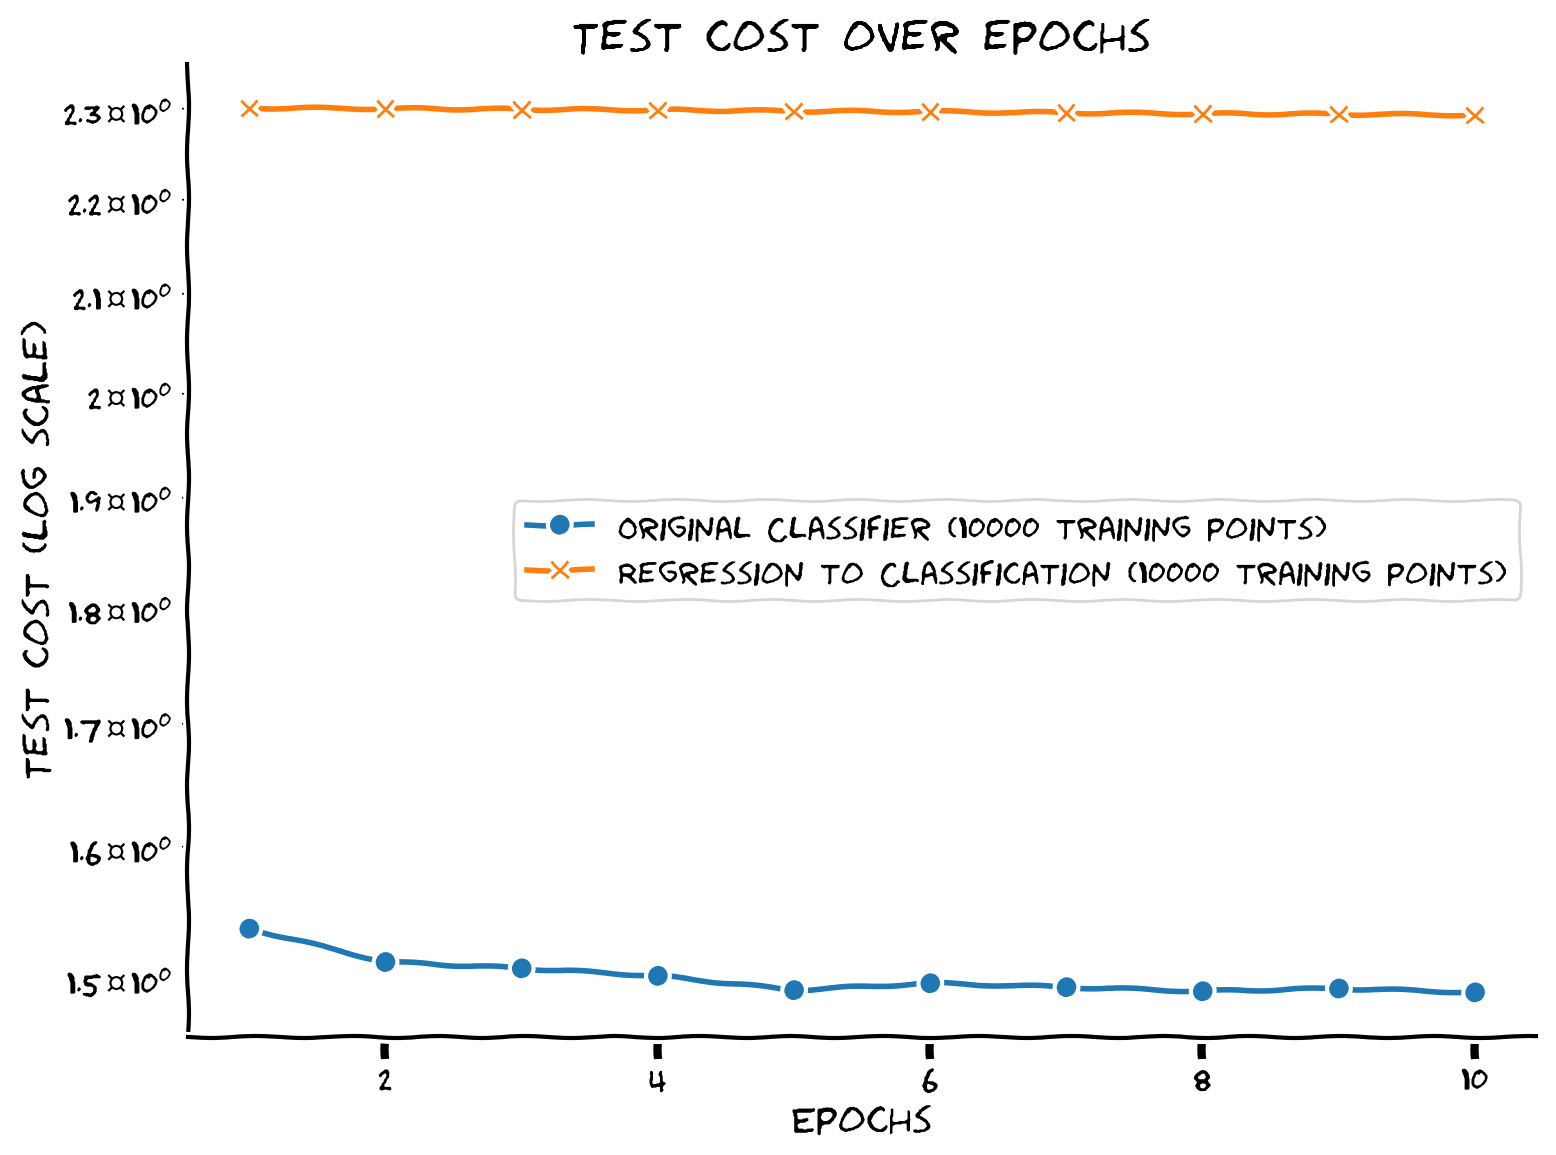

In [47]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1

    # Plot the autoencoder training cost
    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')

    # Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 5

What did the regression model learn? What does its performance on the classification task after fine-tuning indicate?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_430915db.py)



In [48]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_5")

## Transfer example 2: autoencoder to classification

Now we do the same, but we transfer the weights of the network to predict the total number of on pixels to the autoencoder task. How well do you think this will work?

In [49]:
MODEL_NAME_SOURCE = "models/ConvNet_autoencoder_10000_epoch_10.pth"
model_source = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model

model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


In [50]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "autoencoder_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer2, my_train_cost_transfer2, my_val_cost_transfer2, my_test_cost_transfer2 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.04398| Val cost:  1.98295| Test cost:  1.97678|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_1.pth
Epoch: 2| Train cost:  1.92582| Val cost:  1.87753| Test cost:  1.88658|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_2.pth
Epoch: 3| Train cost:  1.89555| Val cost:  1.87372| Test cost:  1.87916|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_3.pth
Epoch: 4| Train cost:  1.89086| Val cost:  1.87904| Test cost:  1.87867|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_4.pth
Epoch: 5| Train cost:  1.88844| Val cost:  1.86691| Test cost:  1.87358|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_5.pth
Epoch: 6| Train cost:  1.88728| Val cost:  1.86530| Test cost:  1.87271|
Saving the model: models/ConvNet_autoencoder_classification_10000_epoch_6.pth
Epoch: 7| Train cost:  1.88545| Val cost:  1.85580| Test cost:  1.87227|
Saving the model: mod

We compare the performance of the transferred model with the original network.

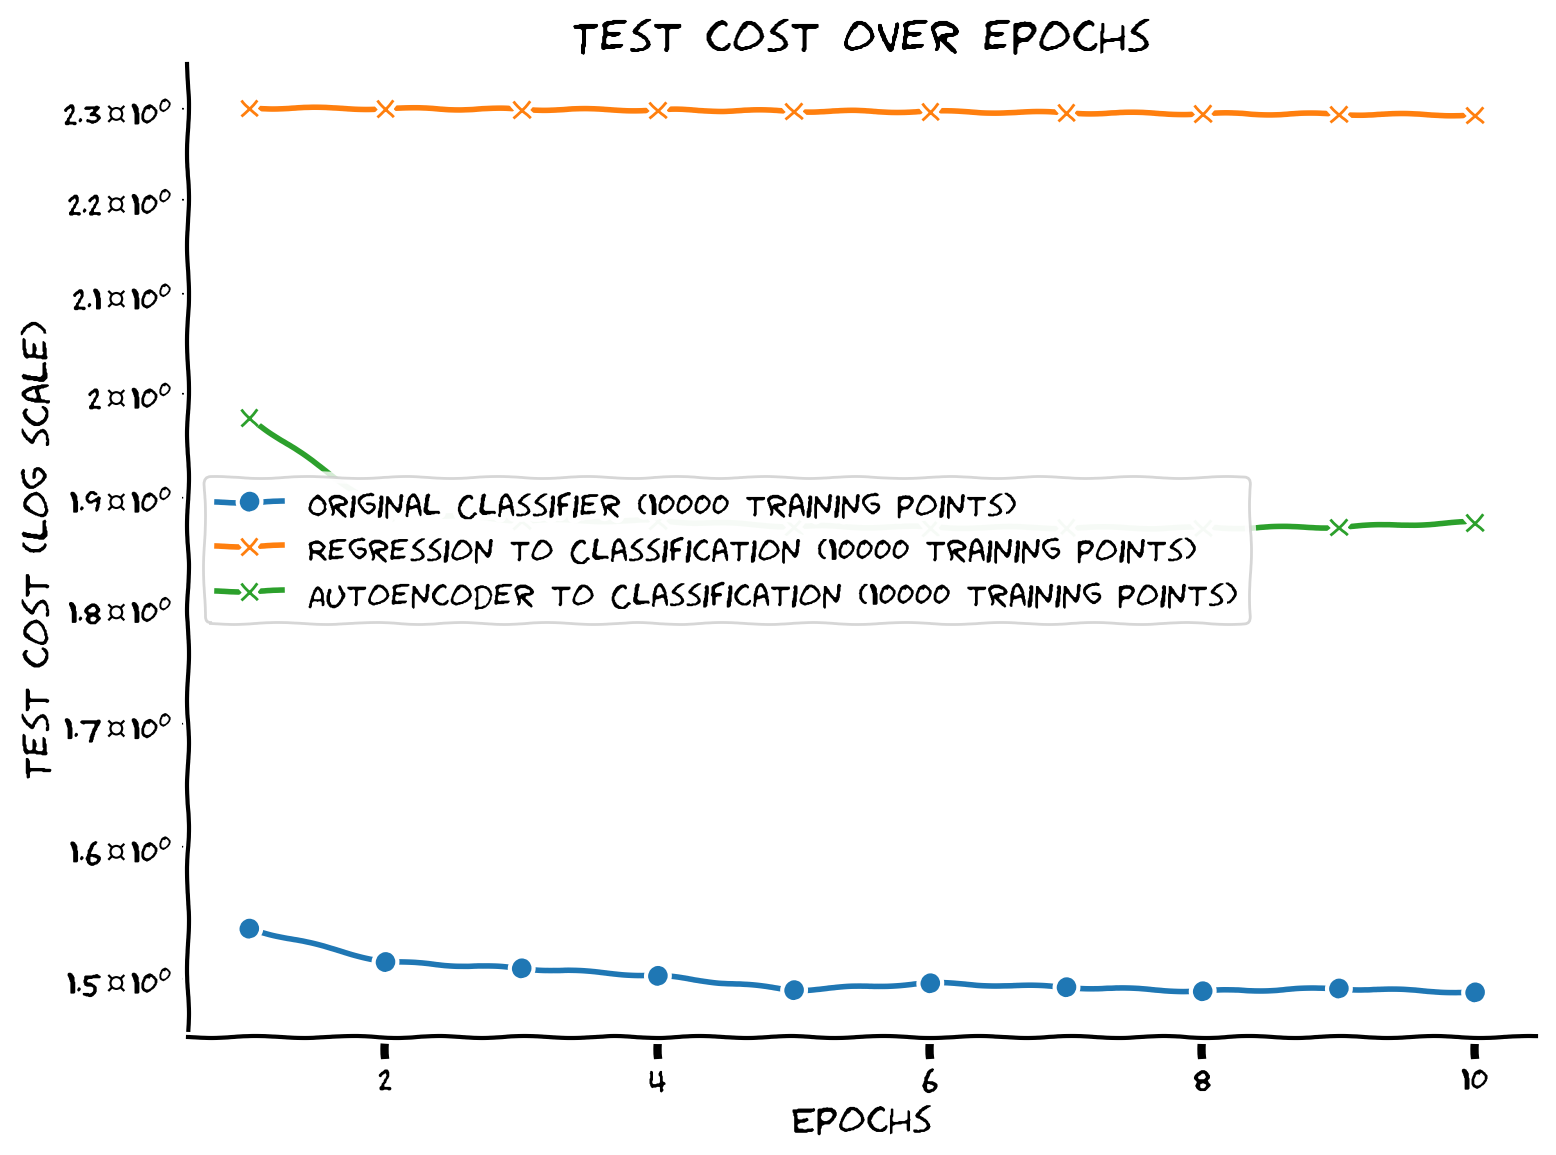

In [51]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    epochs_transfer_2 = my_epoch_transfer2
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1
    test_cost_2 = my_test_cost_transfer2

    # Plot the autoencoder training cost
    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')

    # Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')

# Plot the classification_autoencoder training cost
    plt.plot(epochs_transfer_2, test_cost_2, marker='x', linestyle='-', label='Autoencoder to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 6

How well does the representation learned on the autoencoder transfer to classification?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_733ba3ce.py)



In [52]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_6")

## Transfer example 3: inpainting to classification

Finally, we'll transfer the weights of the inpainting network to the classification network. How well do you think this will work?

In [53]:
MODEL_NAME_SOURCE = "models/ConvNet_inpainting_10000_epoch_10.pth"
M = 16
model_source = Autoencoder(ConvNeuralNet(), BottleneckLayer(M), ConvNeuralNetDecoder(M))

# Load the checkpoint
checkpoint = torch.load(MODEL_NAME_SOURCE)

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model_source.load_state_dict(model_state_dict)

# Define the destination model

model_destination = ClassificationConvNet(ConvNeuralNet(), ClassificationOutputLayer())

# Number of layers to transfer and freeze
N = 8

# Transfer and freeze layers
copy_and_freeze_layers(model_source, model_destination, N)

['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc.weight', 'fc.bias']
Copied conv1.weight
Copied conv1.bias
Copied conv2.weight
Copied conv2.bias
Copied fc1.weight
Copied fc1.bias
Copied fc2.weight
Copied fc2.bias
8
froze  ConvNet.conv1.weight
froze  ConvNet.conv1.bias
froze  ConvNet.conv2.weight
froze  ConvNet.conv2.bias
froze  ConvNet.fc1.weight
froze  ConvNet.fc1.bias
froze  ConvNet.fc2.weight
froze  ConvNet.fc2.bias
Copied and froze 8 layers.


In [54]:
set_seed(42)

batch_size = 64  # Define your batch size

test_loader_transfer = torch.utils.data.DataLoader(dataset = test_dataset_transfer,
                                           batch_size = batch_size,
                                           shuffle = True)
sampled_train_loader, sampled_val_loader = get_random_sample_train_val(train_dataset, val_dataset, batch_size, N_train_data)

# Optimizer
optimizer = optim.Adam(params=model_destination.parameters(), lr=0.001)

# Training parameters
N_train_data = 10000
task_name = "inpainting_classification"
epochs_max = 10  # Number of epochs
acc_flag = False  # Whether to calculate accuracy
triplet_flag = False  # Whether to use triplet loss

# Call the train_transfer function
my_epoch_transfer3, my_train_cost_transfer3, my_val_cost_transfer3, my_test_cost_transfer3 = train_transfer(
    model_destination,
    sampled_train_loader,
    sampled_val_loader,
    test_loader_transfer,
    cost_classification,
    optimizer,
    epochs_max,
    acc_flag,
    triplet_flag,
    task_name,
    N_train_data
)

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch: 1| Train cost:  2.07323| Val cost:  2.01216| Test cost:  1.98450|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_1.pth
Epoch: 2| Train cost:  1.99802| Val cost:  1.99067| Test cost:  1.96863|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_2.pth
Epoch: 3| Train cost:  1.98867| Val cost:  1.99427| Test cost:  1.96106|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_3.pth
Epoch: 4| Train cost:  1.98495| Val cost:  1.98658| Test cost:  1.96494|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_4.pth
Epoch: 5| Train cost:  1.98131| Val cost:  1.98166| Test cost:  1.95945|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_5.pth
Epoch: 6| Train cost:  1.92082| Val cost:  1.90131| Test cost:  1.88766|
Saving the model: models/ConvNet_inpainting_classification_10000_epoch_6.pth
Epoch: 7| Train cost:  1.90179| Val cost:  1.87191| Test cost:  1.85489|
Saving the model: models/Co

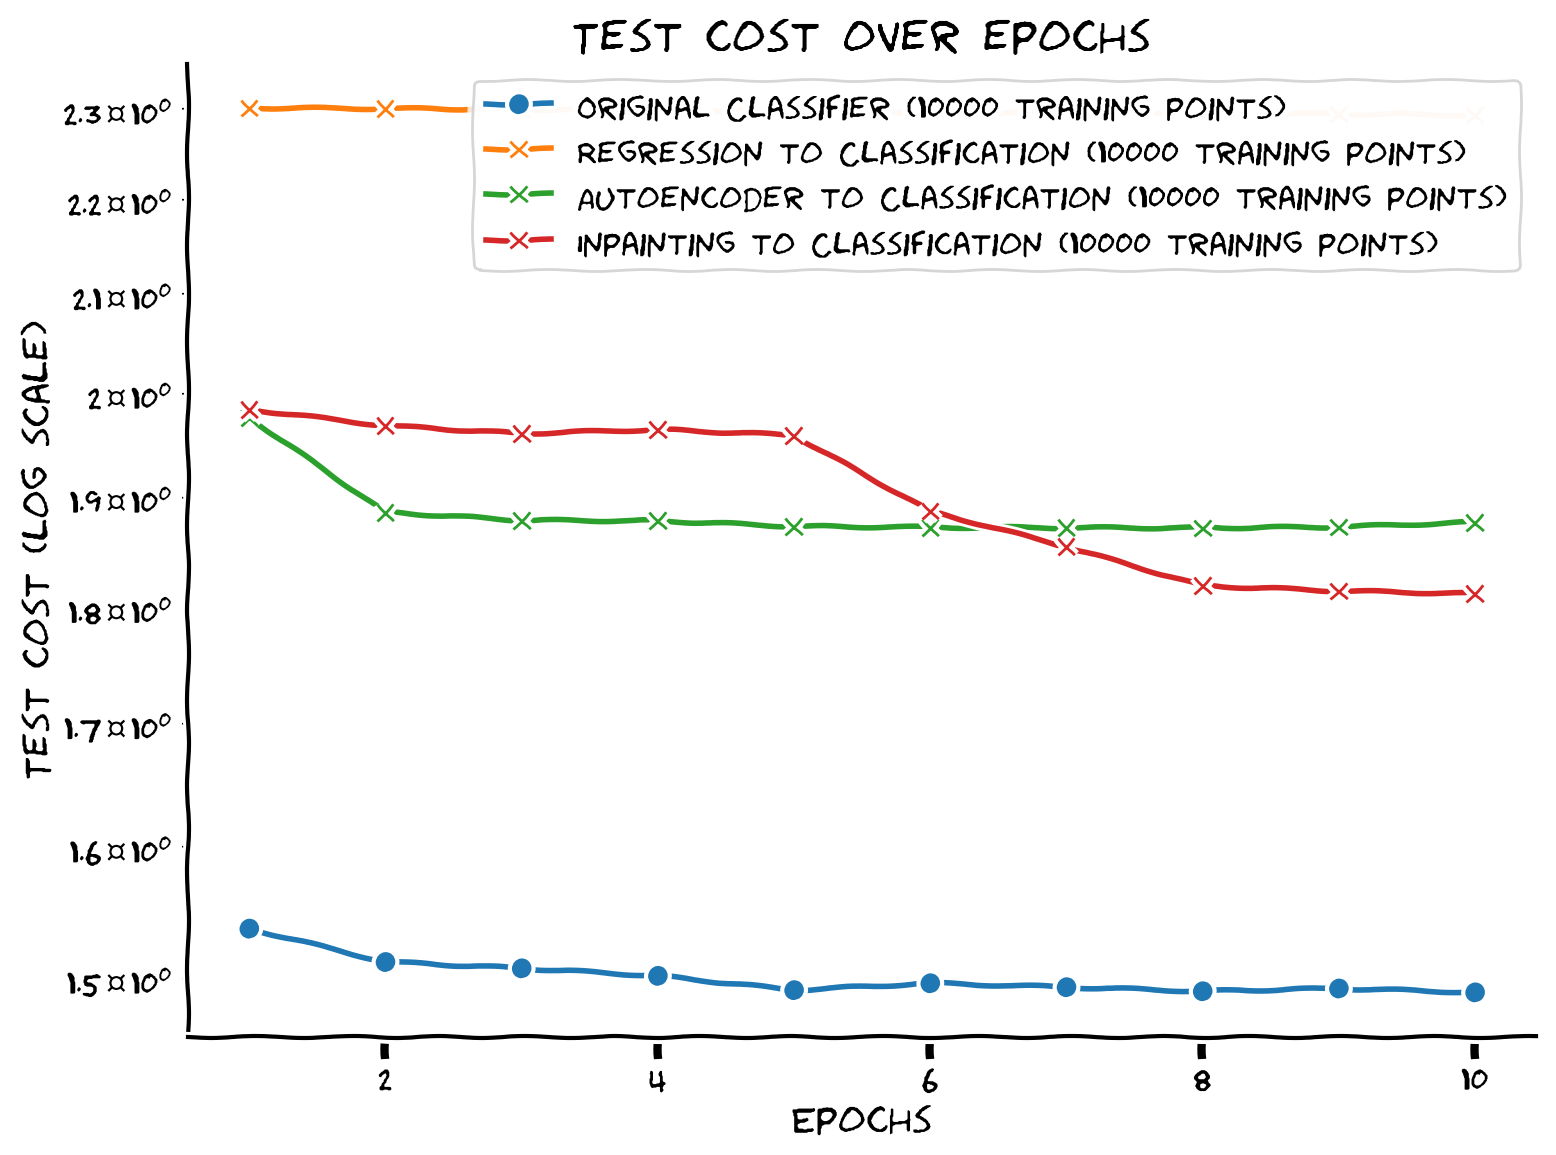

In [55]:
# Create a single plot for all training costs with a logarithmic scale
with plt.xkcd():
    plt.figure(figsize=(8, 6))  # Set the figure size

    epochs = my_epoch_Classification[-1]
    epochs_transfer_1 = my_epoch_transfer1
    epochs_transfer_2 = my_epoch_transfer2
    epochs_transfer_3 = my_epoch_transfer3
    test_cost = my_test_cost_Classification[-1]
    test_cost_1 = my_test_cost_transfer1
    test_cost_2 = my_test_cost_transfer2
    test_cost_3 = my_test_cost_transfer3

    plt.plot(epochs, test_cost, marker='o', linestyle='-', label='Original Classifier (10000 training points)')
    plt.plot(epochs_transfer_1, test_cost_1, marker='x', linestyle='-', label='Regression to Classification (10000 training points)')
    plt.plot(epochs_transfer_2, test_cost_2, marker='x', linestyle='-', label='Autoencoder to Classification (10000 training points)')
    plt.plot(epochs_transfer_3, test_cost_3, marker='x', linestyle='-', label='Inpainting to Classification (10000 training points)')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Test cost (log scale)')
    plt.title('Test cost over epochs')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale

    # Add the legend and grid
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

### Discussion point 7

What does the test loss across these three networks (regression, autoencoder, inpainting) tell us about the representations learned by the networks?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_329eb9d7.py)



In [56]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_7")

## Bonus discussion point 8


How would you find out if the representations learned by the networks are similar or different, apart from their performance on downstream tasks?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D2_ComparingTasks/solutions/W1D2_Tutorial1_Solution_9e82edae.py)



In [57]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Discussion_Point_8")

---
# Summary

In this tutorial, we've explored the concept of generalization of representation in AI. We trained a network on several distinct tasks, including classification, regression, autoencoding, and inpainting. We explored well a network trained on one task transfers to another. We found that richer tasks, including inpainting and autoencoding, lead to more useful representations for downstream tasks like classification.